# Check How Mahalanobis Distances are Distributed

#### Imports

In [1]:
import os
import shutil
import sys

import matplotlib as mpl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from datetime import datetime

from ensemble_uncertainties.evaluators.evaluator_support import format_time_elapsed, make_columns
from ensemble_uncertainties.evaluators.regression_evaluator import RegressionEvaluator
from ensemble_uncertainties.model_library import models
from ensemble_uncertainties.utils.ad_assessment import rmses_frac

from matplotlib.font_manager import FontProperties

from sklearn.covariance import EmpiricalCovariance
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

#### Settings

In [2]:
mpl.rcParams['figure.dpi'] = 200

#### Constants

In [3]:
RANDOM_SEED = 0
N_SPLITS = 2
TASK = 'regression'
PLOT_FOLDER = './plots/mahalanobis/'

BLACK = [0, 0, 0]
RED = [1, 0, 0]
GREY = [.6, .6, .6]

#### Functions

In [4]:
def load_data_set(name, descriptor):
    """Loads X and y as dataframes from data folder."""
    folder = f'../../../data/featurized/{TASK}/{name}/'
    X_file = f'{folder}{name}_{descriptor}.csv'
    y_file = f'{folder}{name}_y.csv'
    X = pd.read_csv(X_file, sep=';').set_index('id')
    y = pd.read_csv(y_file, sep=';').set_index('id')
    return X, y
        
            
def compute_cv_mahalanobis(X, y, repetitions, n_splits):
    """Computes multiple cross-validated Mahalanobis distances."""
    mahalas = pd.DataFrame()
    start_time = datetime.now()
    for rep_index in tqdm(range(repetitions)):
        kfold = KFold(n_splits=n_splits,
            random_state=rep_index, shuffle=True)
        splits = kfold.split(X)
        split_iter = list(enumerate(splits))
        for split_index, (train_id, test_id) in split_iter:
            # Select train and test fraction
            X_train, X_test = X.iloc[train_id], X.iloc[test_id]
            cov = EmpiricalCovariance().fit(X_train)
            mahala_squared = cov.mahalanobis(X_test)
            mahala = np.sqrt(mahala_squared)
            mahala_df = pd.DataFrame(mahala, index=X_test.index)
            mahalas = pd.concat([mahalas, mahala_df], axis=1)
    mahalas.columns = make_columns(repetitions, n_splits)
    mahala_time = datetime.now() - start_time
    return mahalas, mahala_time


def run_evaluation(X, y, model_name, repetitions, n_splits):
    """Performs a run with the RegressionEvaluator."""
    evaluator = RegressionEvaluator(
        model=models['regression'][model_name],
        repetitions=repetitions,
        n_splits=n_splits,
        verbose=False
    )
    evaluator.perform(X, y)
    resids = evaluator.test_ensemble_preds['resid']
    uncertainties = evaluator.test_ensemble_preds['sdep']
    evaluator_time = evaluator.overall_run_time
    return resids, uncertainties, evaluator_time


def plot_comparison(oracle_rmses, measure_rmses, mahalanobis_rmses, evaluator_time, mahala_time, title, ax1, ax2, fig):
    """Plots confidence curves for several evaluators."""
    n_splitss = list()
    times = list()
    formatted_times = list()
    # Plot uncertainty performances
    ax1.grid(zorder=1000)
    x_space = np.linspace(0.0, 100.0, len(oracle_rmses))
    ax1.plot(x_space, oracle_rmses, zorder=100, color=BLACK,
        label=f'Oracle')
    ax1.plot(x_space, measure_rmses, zorder=100, color=RED,
        label=f'SDEP')
    ax1.plot(x_space, mahalanobis_rmses, zorder=100, color=GREY,
        label=f'Med. Mahal.')
    ax1.set_title(title)
    ax1.set_xlabel('Percentile')
    ax1.set_ylabel('$RMSE$')
    ax1.legend()
    # Plot times
    ax2.grid(zorder=1000)
    times = [evaluator_time.total_seconds(), mahala_time.total_seconds()]
    evaluator_time_formatted = format_time_elapsed(evaluator_time).replace('.', '\n')
    mahala_time_formatted = format_time_elapsed(mahala_time).replace('.', '\n')
    formatted_times = [
        evaluator_time_formatted if evaluator_time_formatted else '< 1 second',
        # Whitespace must be added at the end for formatting of the bars
        mahala_time_formatted if mahala_time_formatted else '< 1 second '
    ]
    ax2.bar(formatted_times, times, zorder=100, label='',
        color=[RED, GREY])
    ax2.set_title('')
    ax2.set_xlabel('')
    ax2.set_ylabel('Runtime [s]')     
    colors = dict(zip(['SDEP', 'Med. Mahal.'], [RED, GREY]))        
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    ax2.legend(handles, labels)
    # Re-arrange legends to last axis, so that the legend stays ontop
    all_axes = fig.get_axes()
    for axis in all_axes:
        legend = axis.get_legend()
        if legend is not None:
            legend.remove()
            all_axes[-1].add_artist(legend)


def compare_median(name, descriptor, model_names, repetitions, n_splits=N_SPLITS, plots_folder=PLOT_FOLDER):
    """Compares the median of the Mahalanobis distance to the ensemble uncertainty."""
    X, y = load_data_set(name, descriptor)
    print('Computing Mahalanobis distances.')
    mahalanobis, mahala_time = compute_cv_mahalanobis(X, y, repetitions, n_splits)
    mahalanobis_median = mahalanobis.median(axis=1)
    print('Running evaluators.')
    # Prepare plotting
    n_methods = len(model_names)
    fig, pre_axes = plt.subplots(2, n_methods, figsize=(5*n_methods, 10))
    # Transpose axes
    axes = zip(*pre_axes)
    for model_name, ax in zip(model_names, axes):
        print(f'At {model_name}.')
        uax, tax = ax
        resids, uncertainties, evaluator_time = run_evaluation(X, y, model_name, repetitions, n_splits)
        oracle_rmses, measure_rmses = rmses_frac(resids, uncertainties)
        _, mahalanobis_rmses = rmses_frac(resids, mahalanobis_median)
        title = f'{name}, {descriptor},\n{model_name}'
        plot_comparison(oracle_rmses, measure_rmses, mahalanobis_rmses, evaluator_time, mahala_time, title, uax, tax, fig)
    print('Plotting.')
    if plots_folder:
        image_path = f'{plots_folder}{name}_{descriptor}_{"_".join(model_names)}_{repetitions}reps.png'
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0.01)
    plt.show()

<hr/>

#### Evaluate

Small test run over all entries of the CDDD-featurized Tetrahymena test set

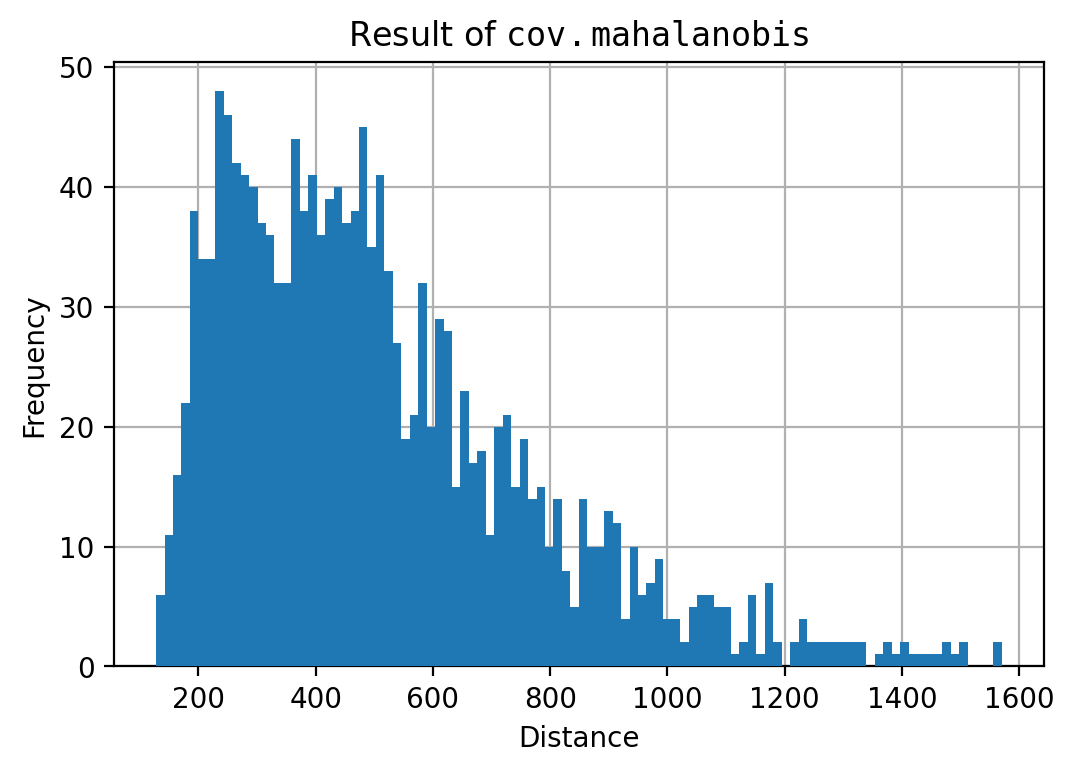

In [5]:
# Load
tetrah_cddd, tetrah_y = load_data_set('tetrahymena', 'cddd')
# Compute cov
cov = EmpiricalCovariance().fit(tetrah_cddd)
# Compute Mahalanobis
mahala_tetrah_cddd = cov.mahalanobis(tetrah_cddd)
# Visualize distribution
plt.grid(zorder=1000)
plt.hist(mahala_tetrah_cddd, bins=100, zorder=100)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Result of $\mathtt{cov.mahalanobis}$')
plt.show()

#### SQRT (since according to sklearn, $\mathtt{.mahalanobis()}$ returns the squared distances)

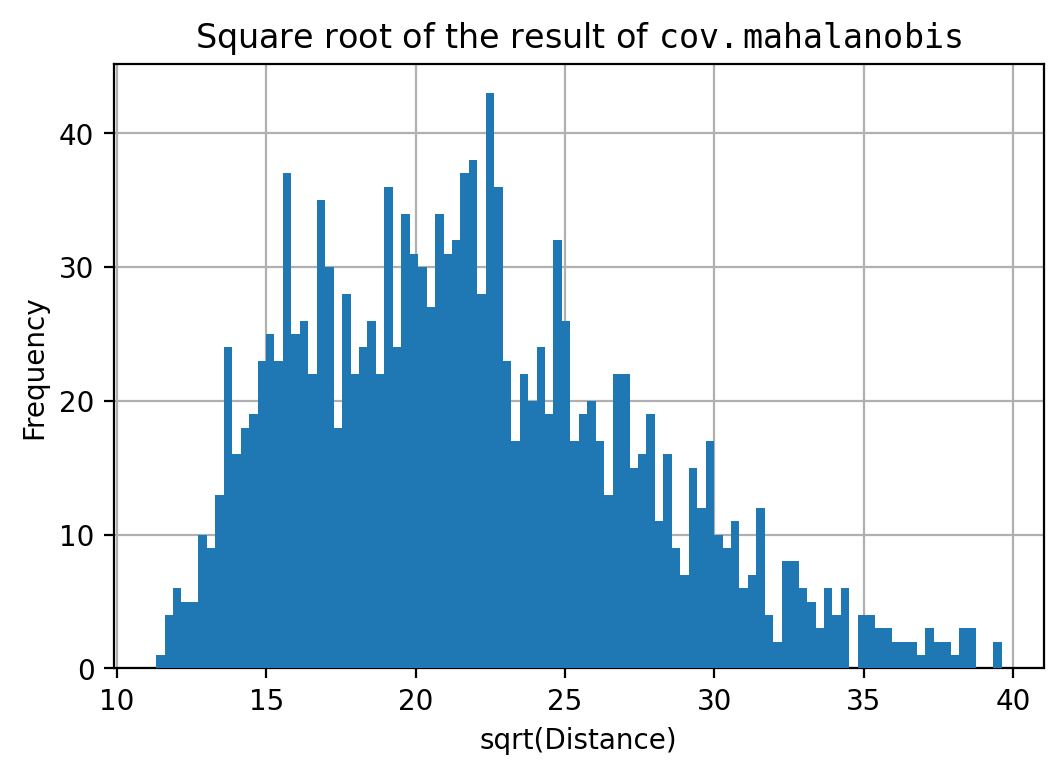

In [6]:
plt.grid(zorder=1000)
plt.hist(np.sqrt(mahala_tetrah_cddd), bins=100, zorder=100)
plt.xlabel('sqrt(Distance)')
plt.ylabel('Frequency')
plt.title('Square root of the result of $\mathtt{cov.mahalanobis}$')
plt.show()

The distances to not look normal-distributed. Try median, just to go sure.

<hr/>

#### Check whether the median over multiple Mahalanobis distances per molecule is a meaningful novelty detection measure

  0%|          | 0/10 [00:00<?, ?it/s]

Computing Mahalanobis distances.


  0%|          | 0/10 [00:00<?, ?it/s]

Running evaluators.
At xgb.


  0%|          | 0/10 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/10 [00:00<?, ?it/s]

At deep.


100%|██████████| 10/10 [00:45<00:00,  4.60s/it]


Plotting.


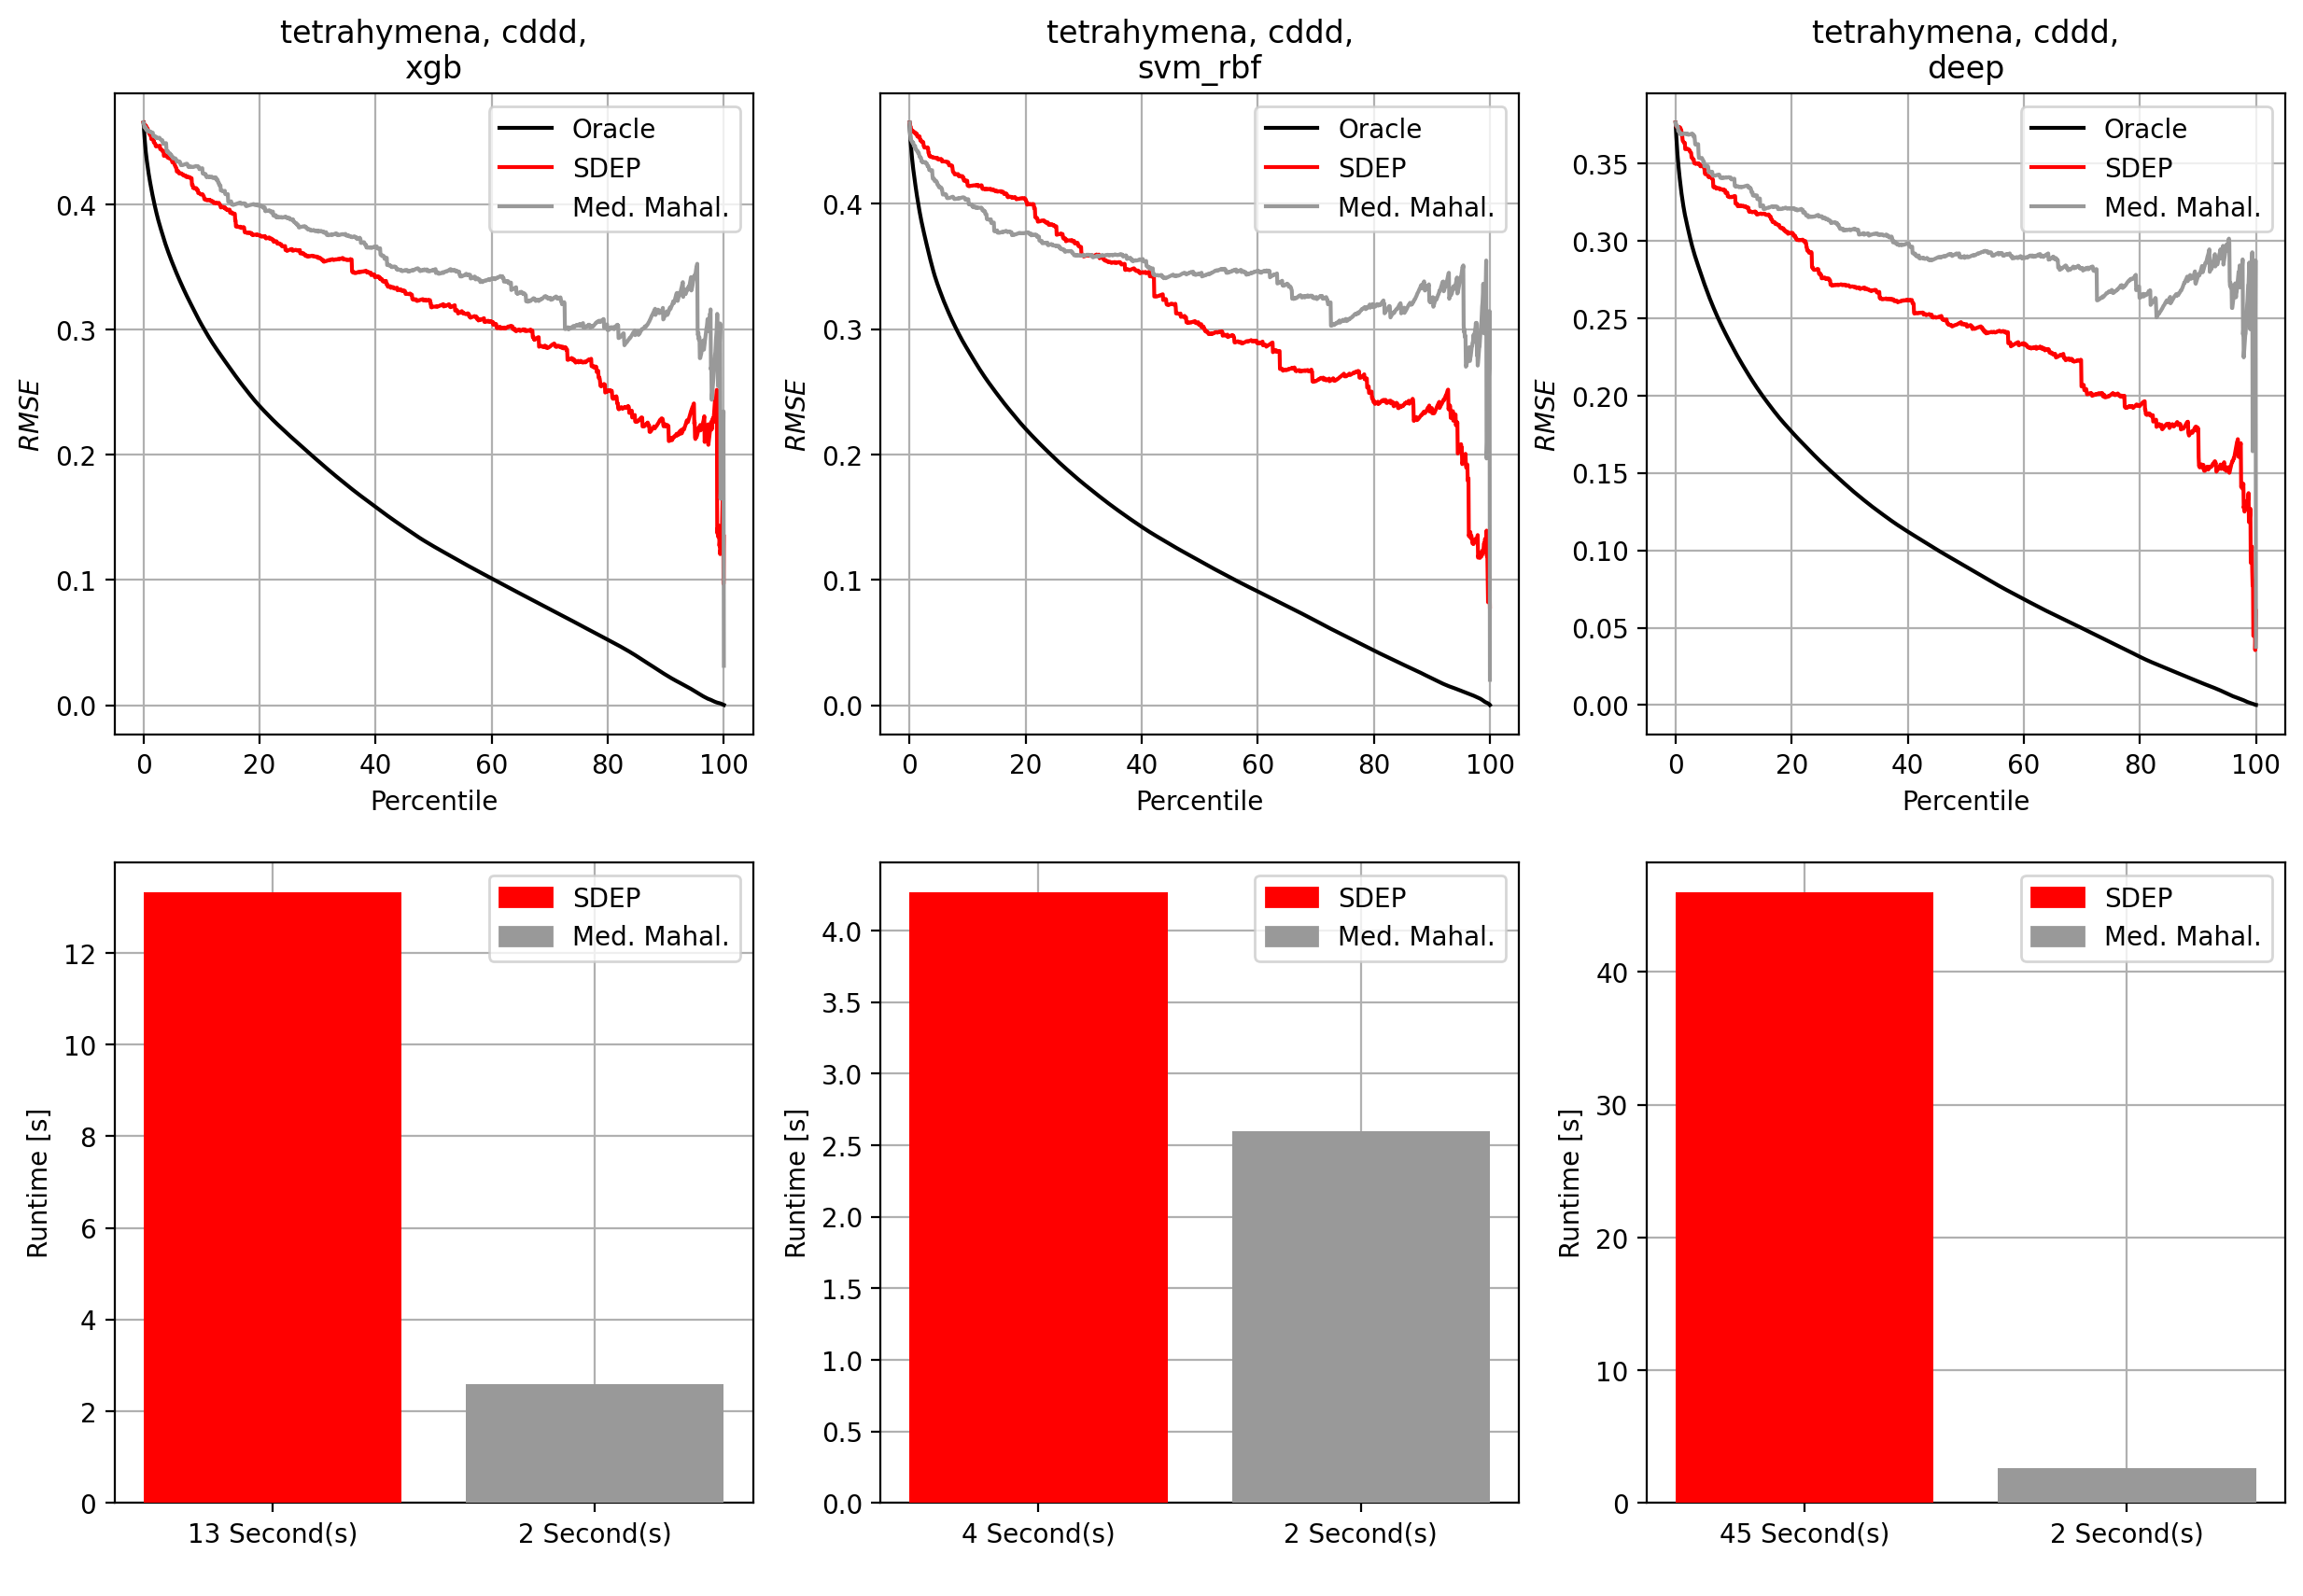

In [7]:
compare_median('tetrahymena', 'cddd', ['xgb', 'svm_rbf', 'deep'], 10)

Looks acceptable. Let's use the median and try out even more examples, for several settings.

<hr/>

#### Evaluate

### Tetrahymena, RDKit descriptors, large-scale evaluation

 60%|██████    | 3/5 [00:00<00:00, 22.94it/s]

Computing Mahalanobis distances.


  0%|          | 0/5 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/5 [00:00<?, ?it/s]

At xgb.


  0%|          | 0/5 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:22<00:00,  4.43s/it]


Plotting.


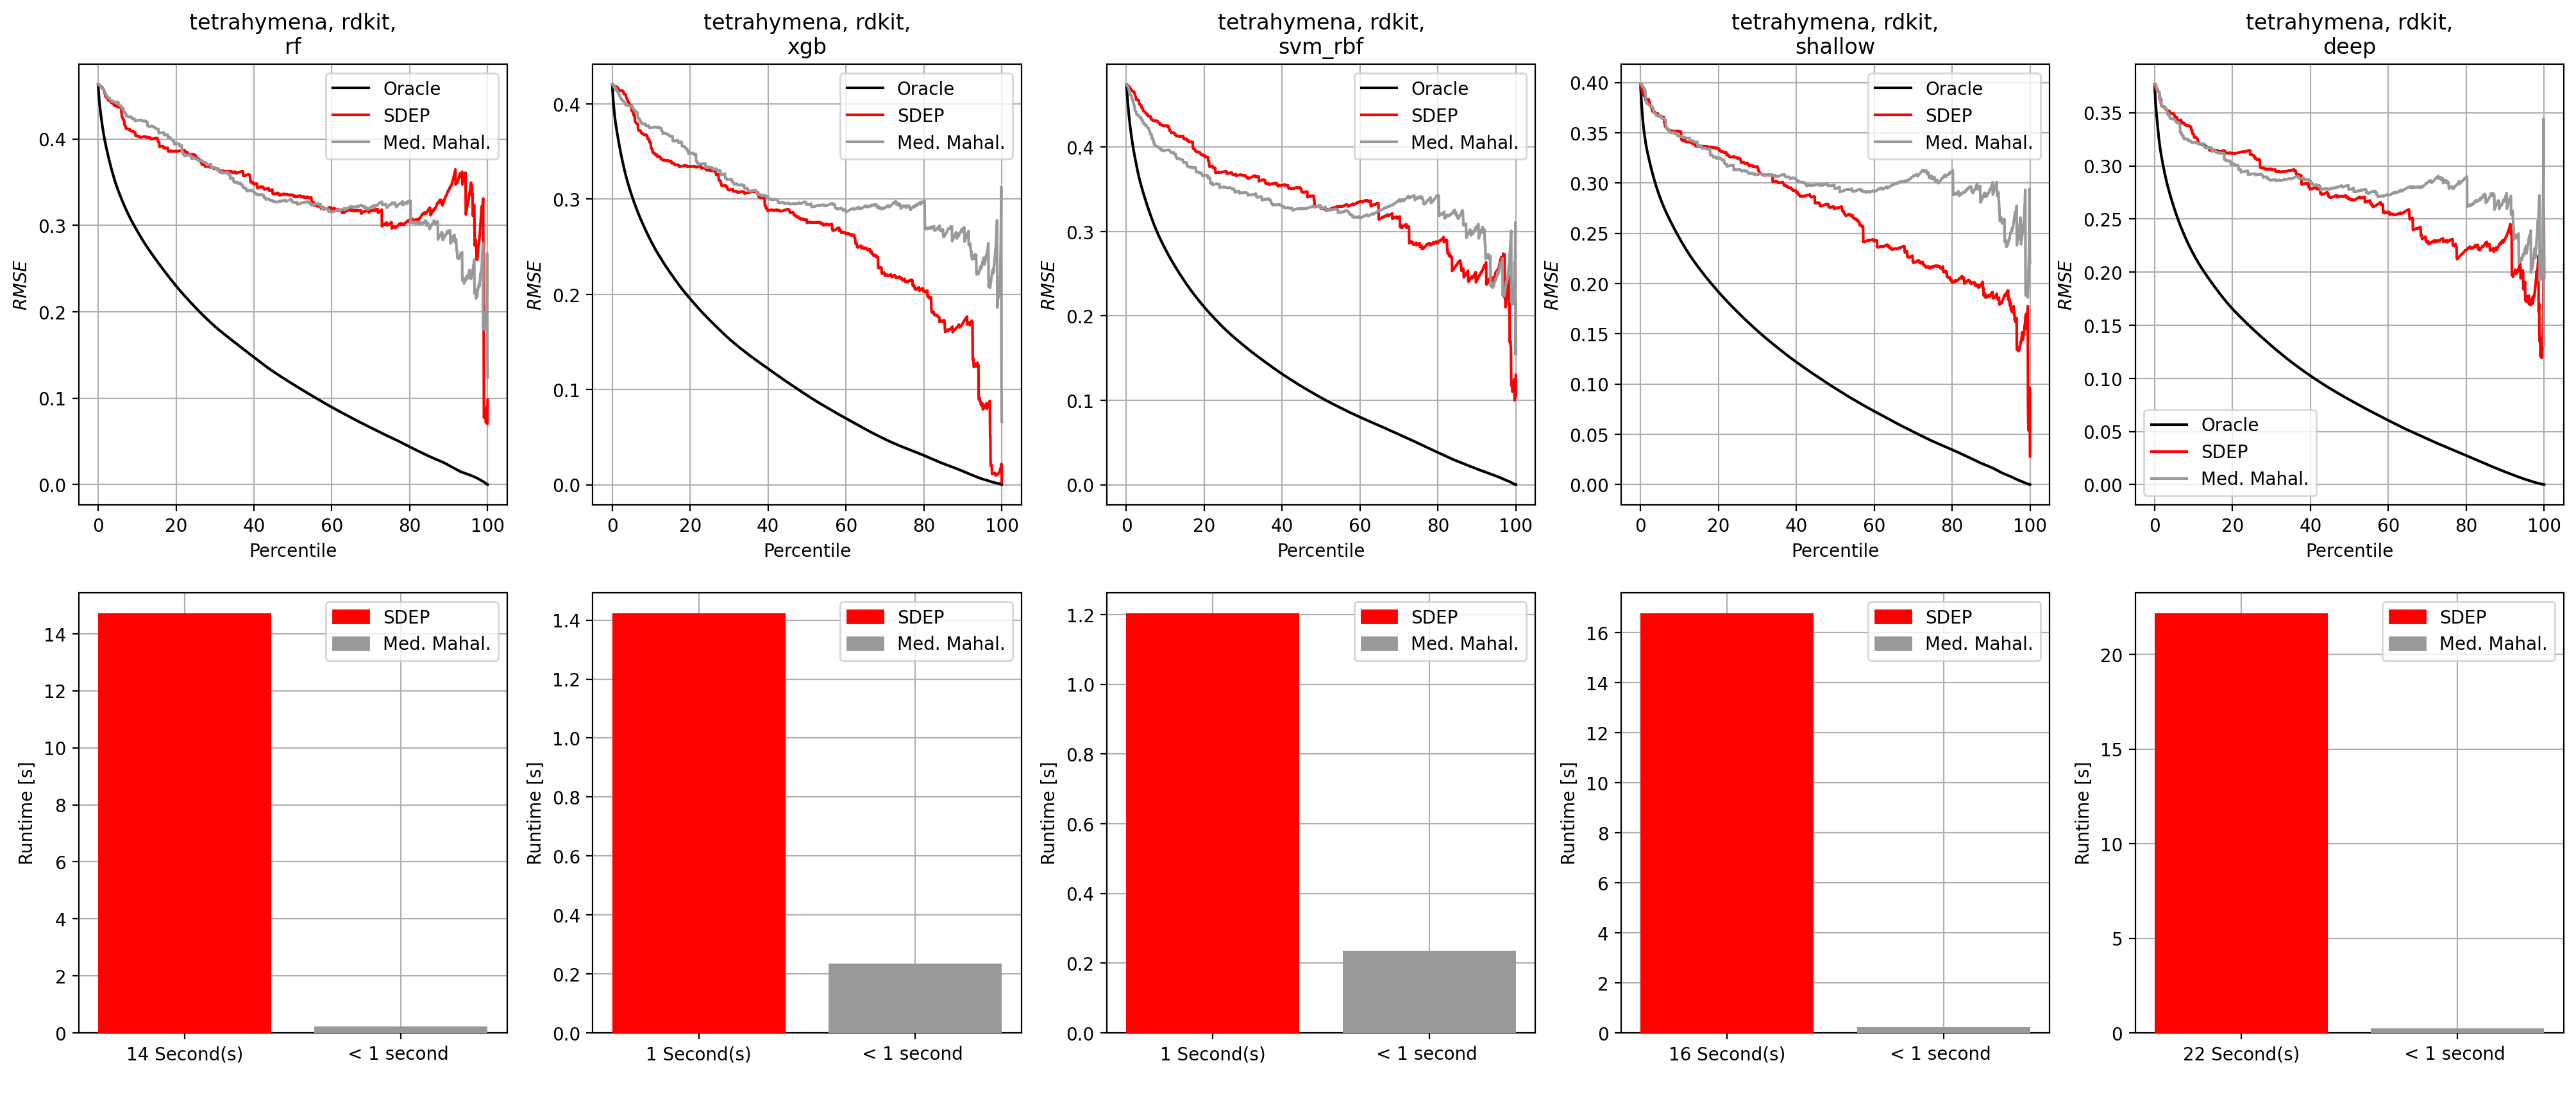

  3%|▎         | 3/100 [00:00<00:06, 15.82it/s]

Computing Mahalanobis distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/100 [00:00<?, ?it/s]

At xgb.


  0%|          | 0/100 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [07:10<00:00,  4.30s/it]


Plotting.


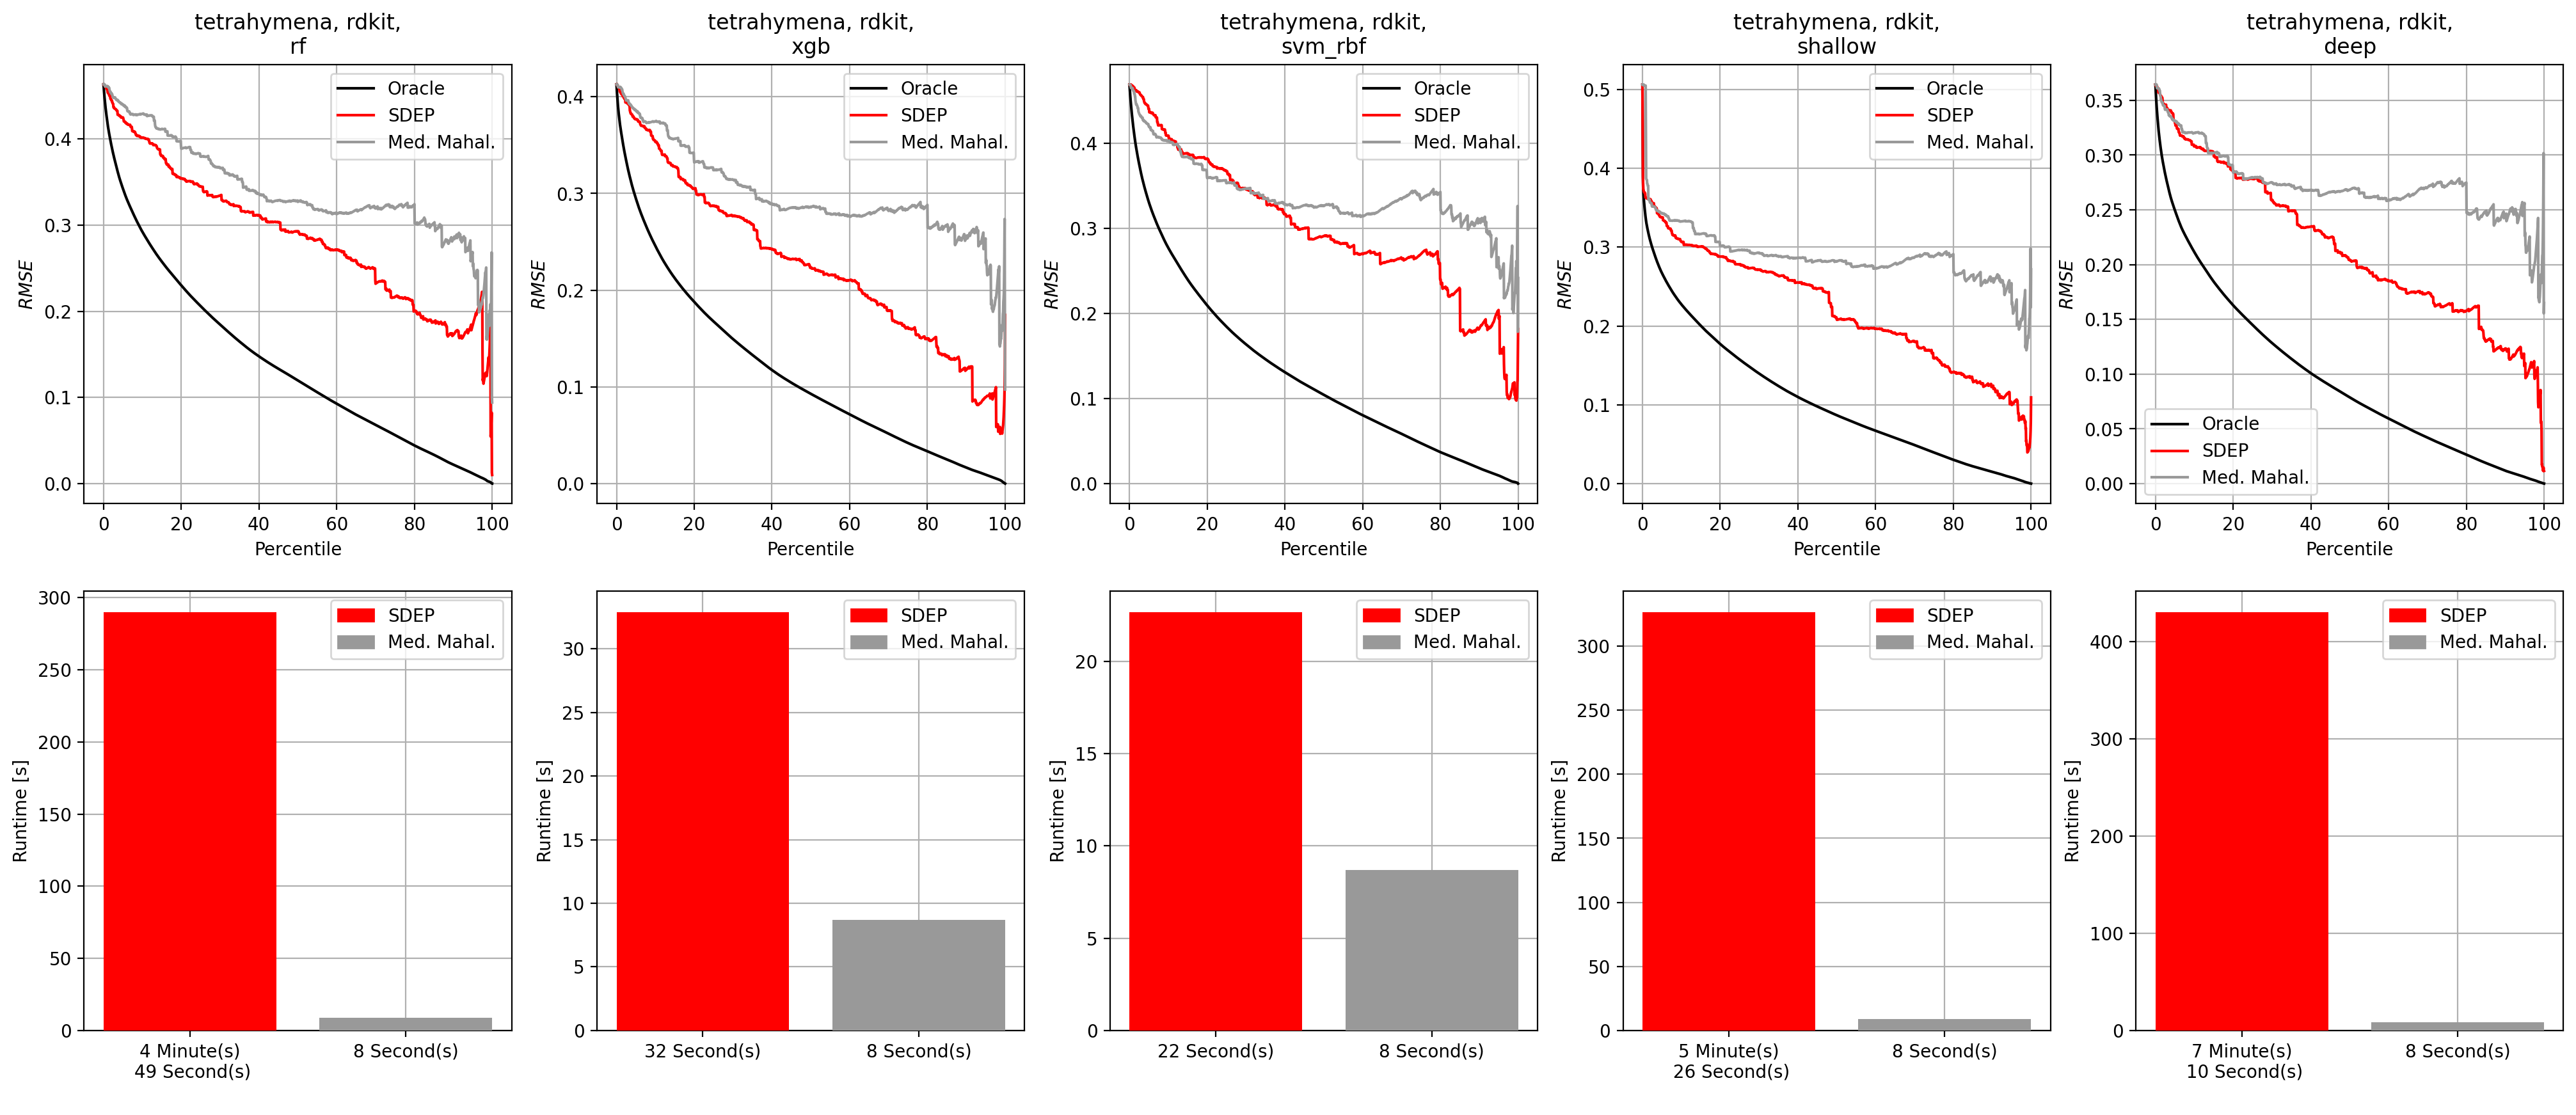

In [8]:
compare_median('tetrahymena', 'rdkit', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('tetrahymena', 'rdkit', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)

### Tetrahymena, CDDD, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]

Computing Mahalanobis distances.


  0%|          | 0/5 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/5 [00:00<?, ?it/s]

At xgb.


  0%|          | 0/5 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:23<00:00,  4.73s/it]


Plotting.


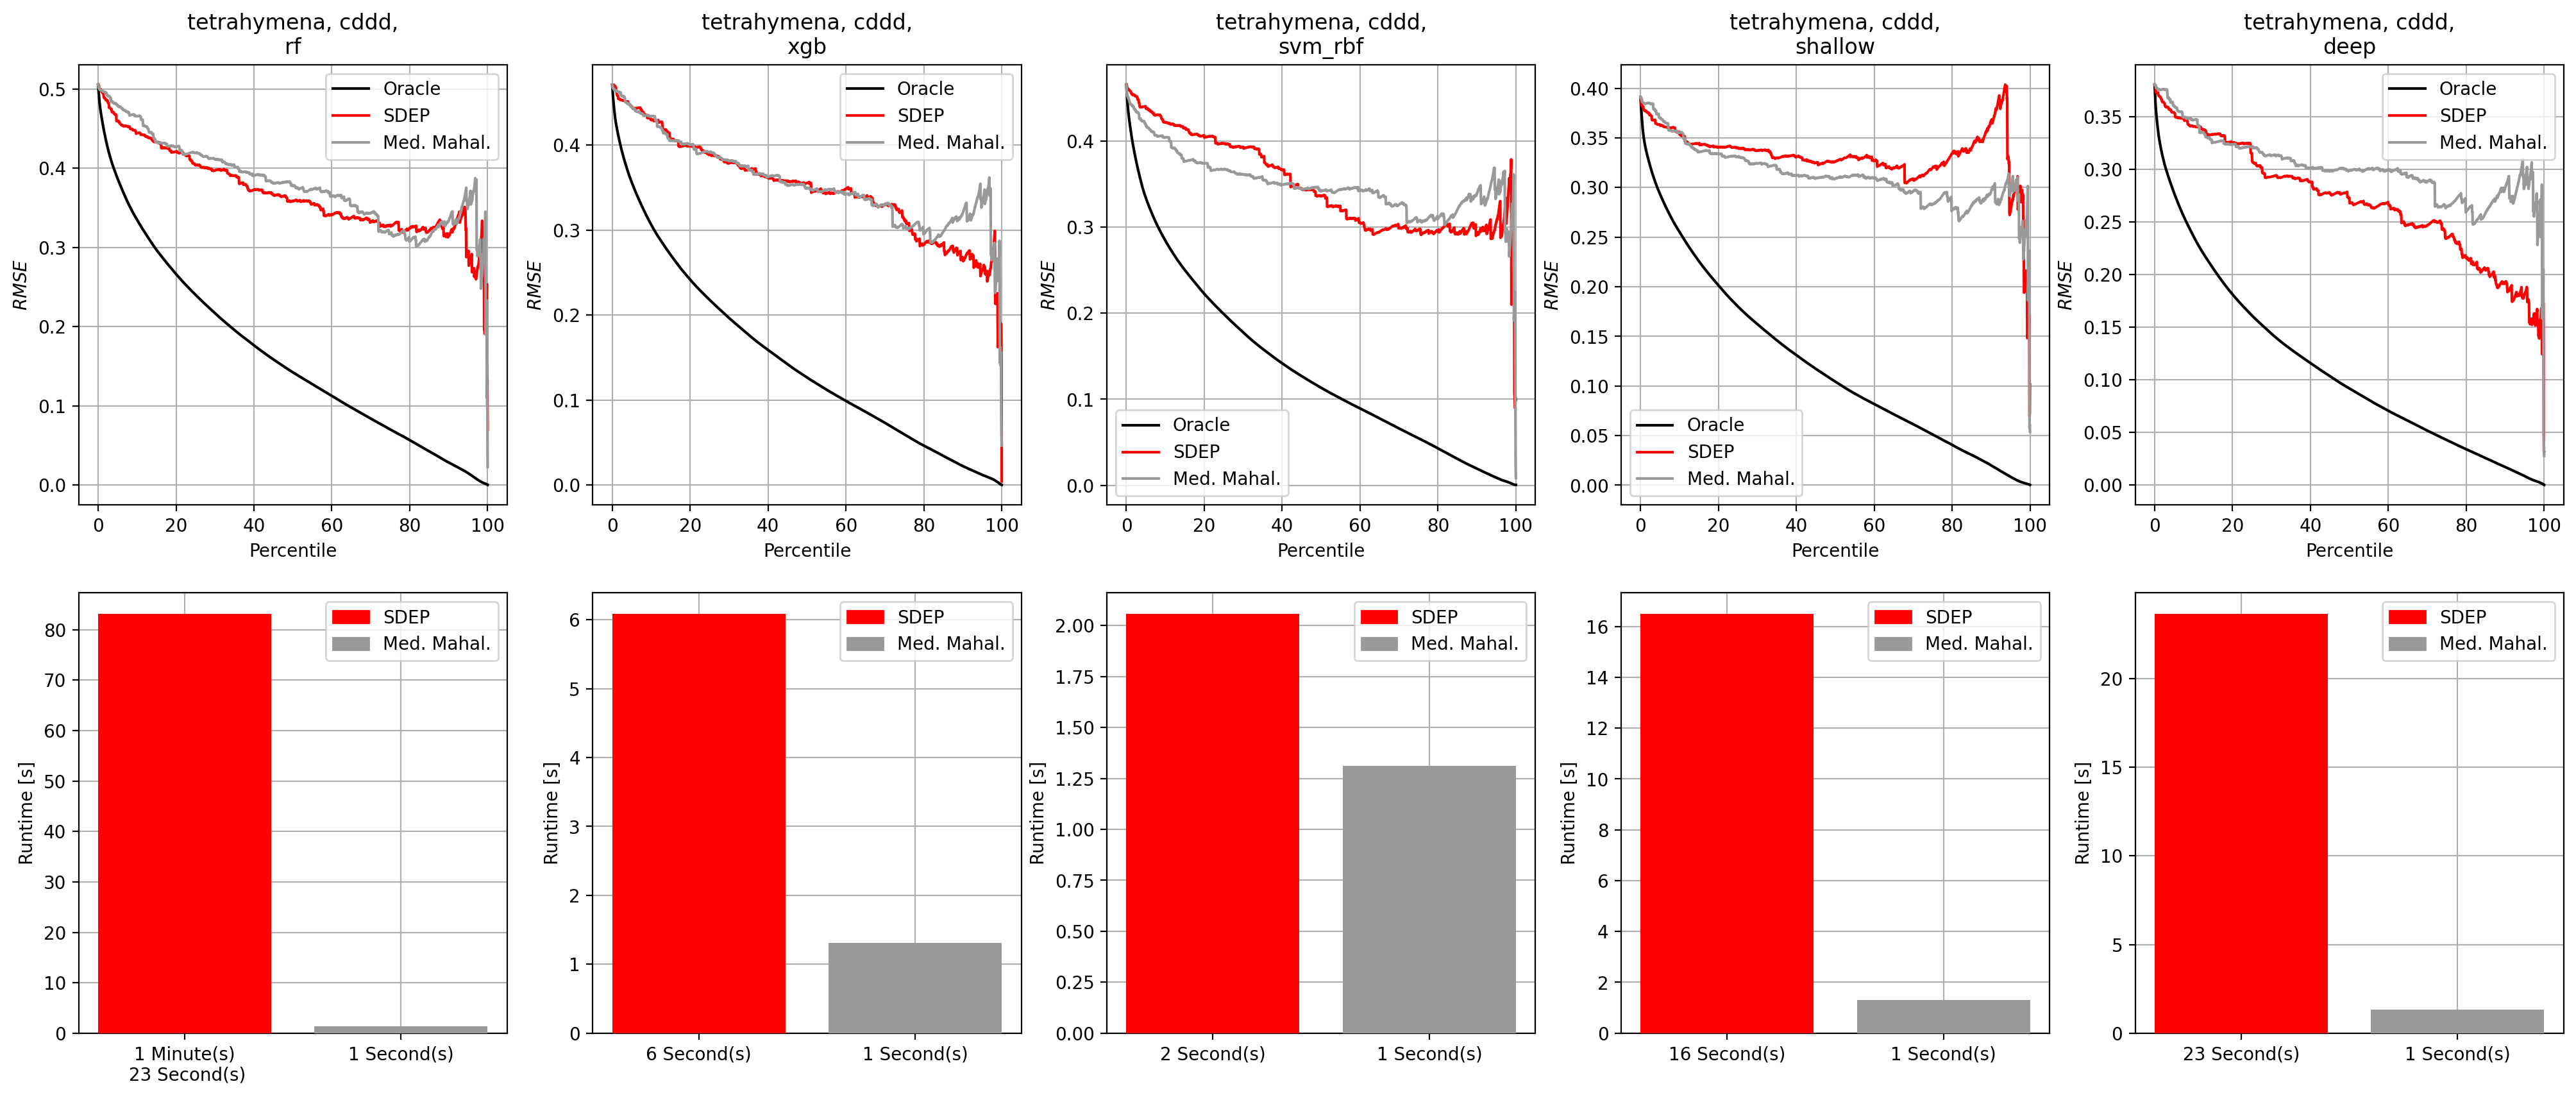

  0%|          | 0/100 [00:00<?, ?it/s]

Computing Mahalanobis distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/100 [00:00<?, ?it/s]

At xgb.


  0%|          | 0/100 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [07:23<00:00,  4.43s/it]


Plotting.


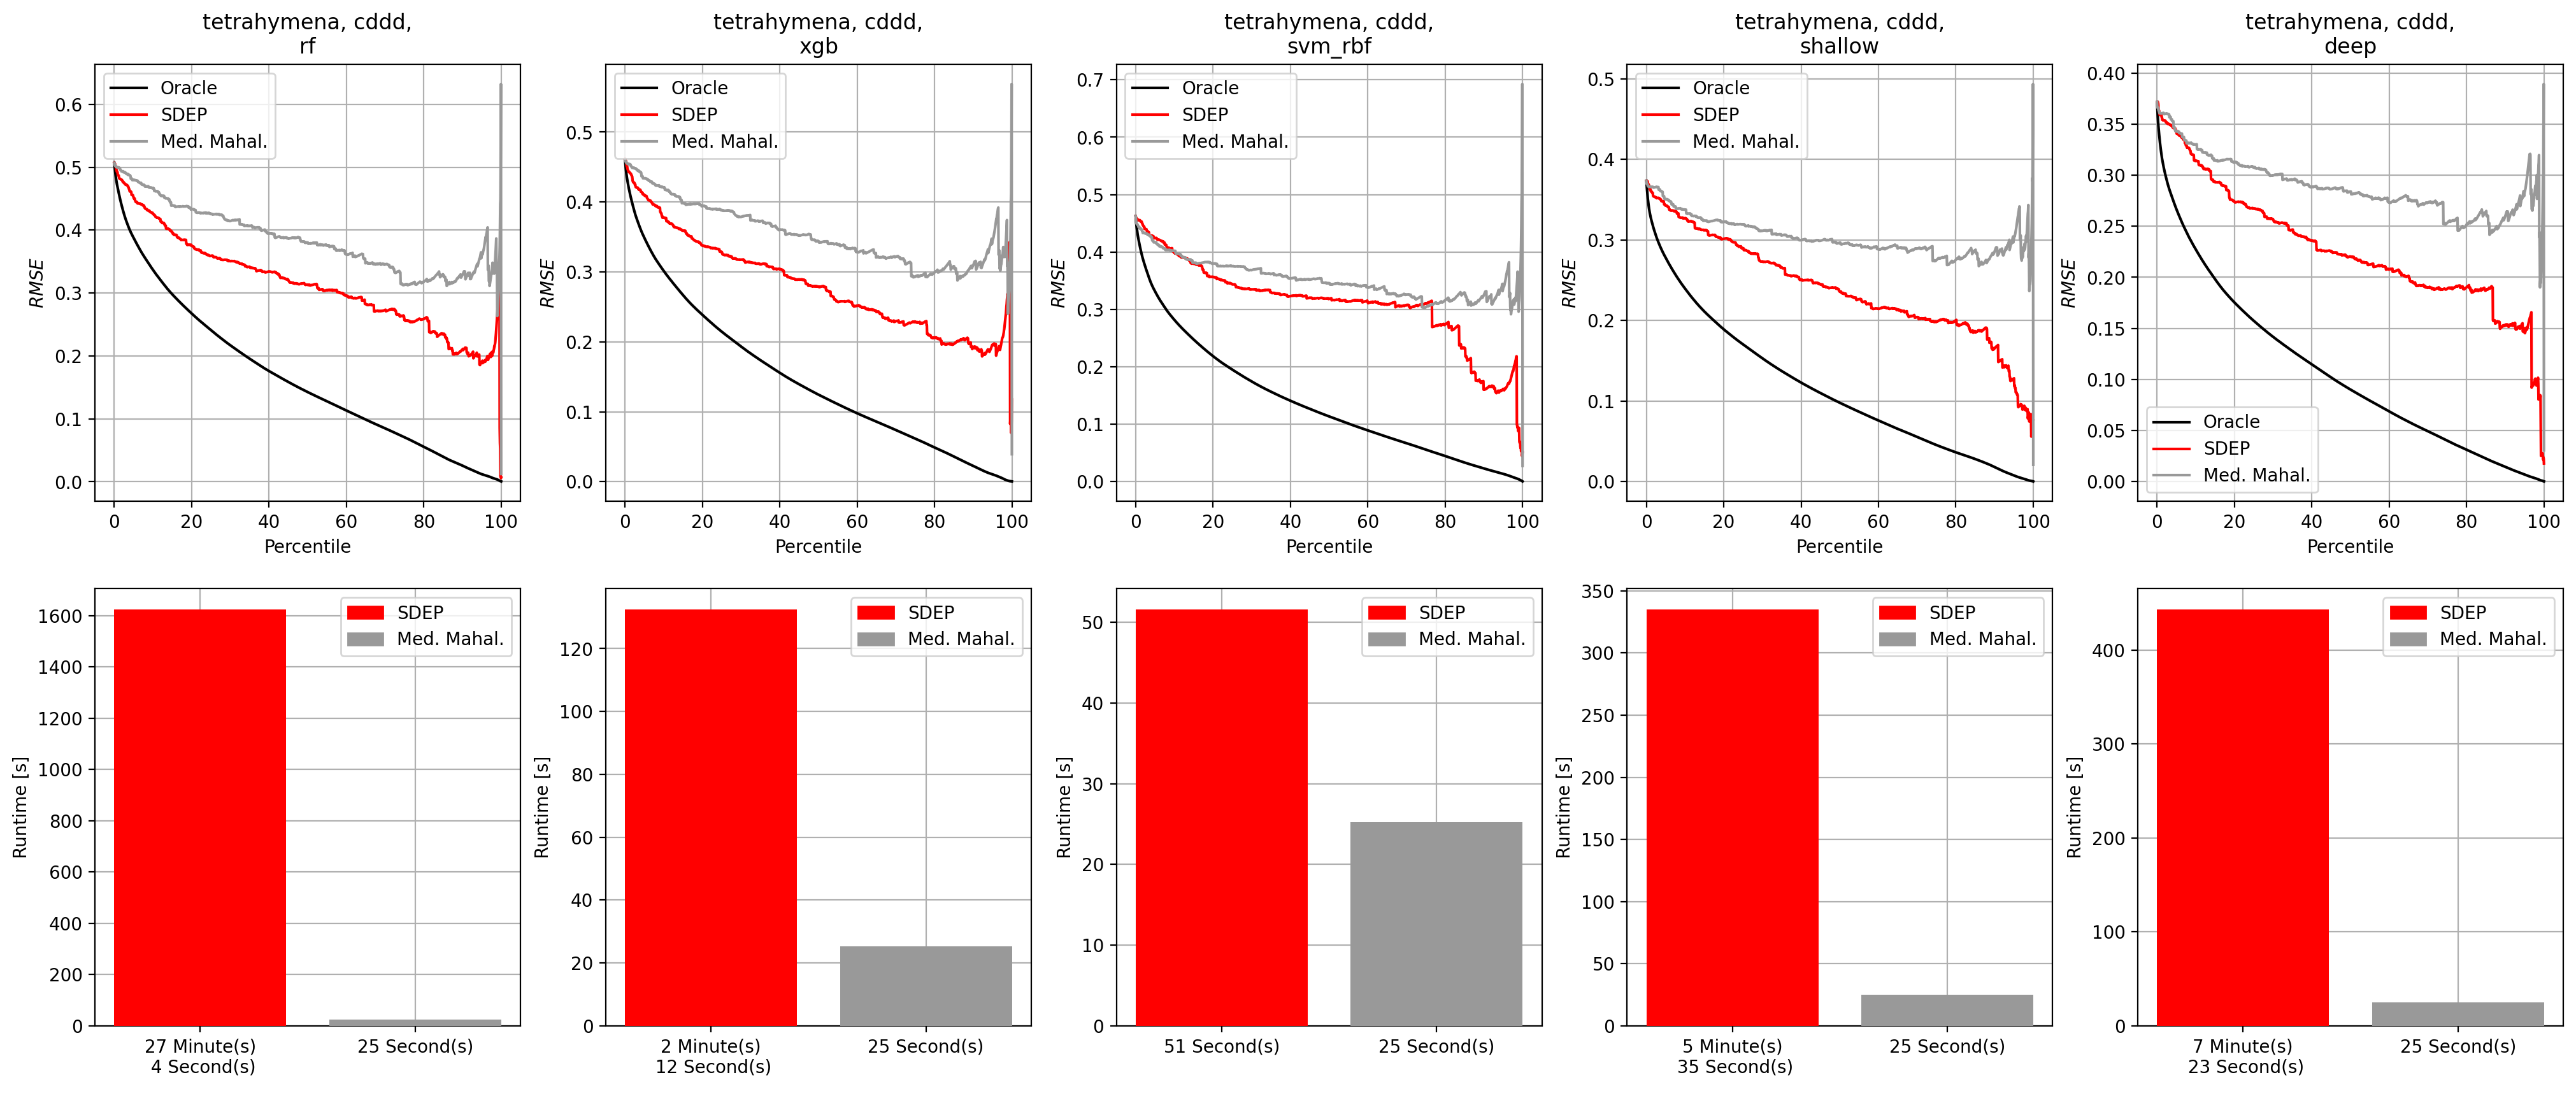

In [9]:
compare_median('tetrahymena', 'cddd', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('tetrahymena', 'cddd', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)

### Tetrahymena, MACCS, large-scale evaluation

 60%|██████    | 3/5 [00:00<00:00, 25.50it/s]

Computing Mahalanobis distances.


  0%|          | 0/5 [00:00<?, ?it/s]

Running evaluators.
At rf.


 20%|██        | 1/5 [00:00<00:00,  5.42it/s]

At xgb.


  0%|          | 0/5 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


Plotting.


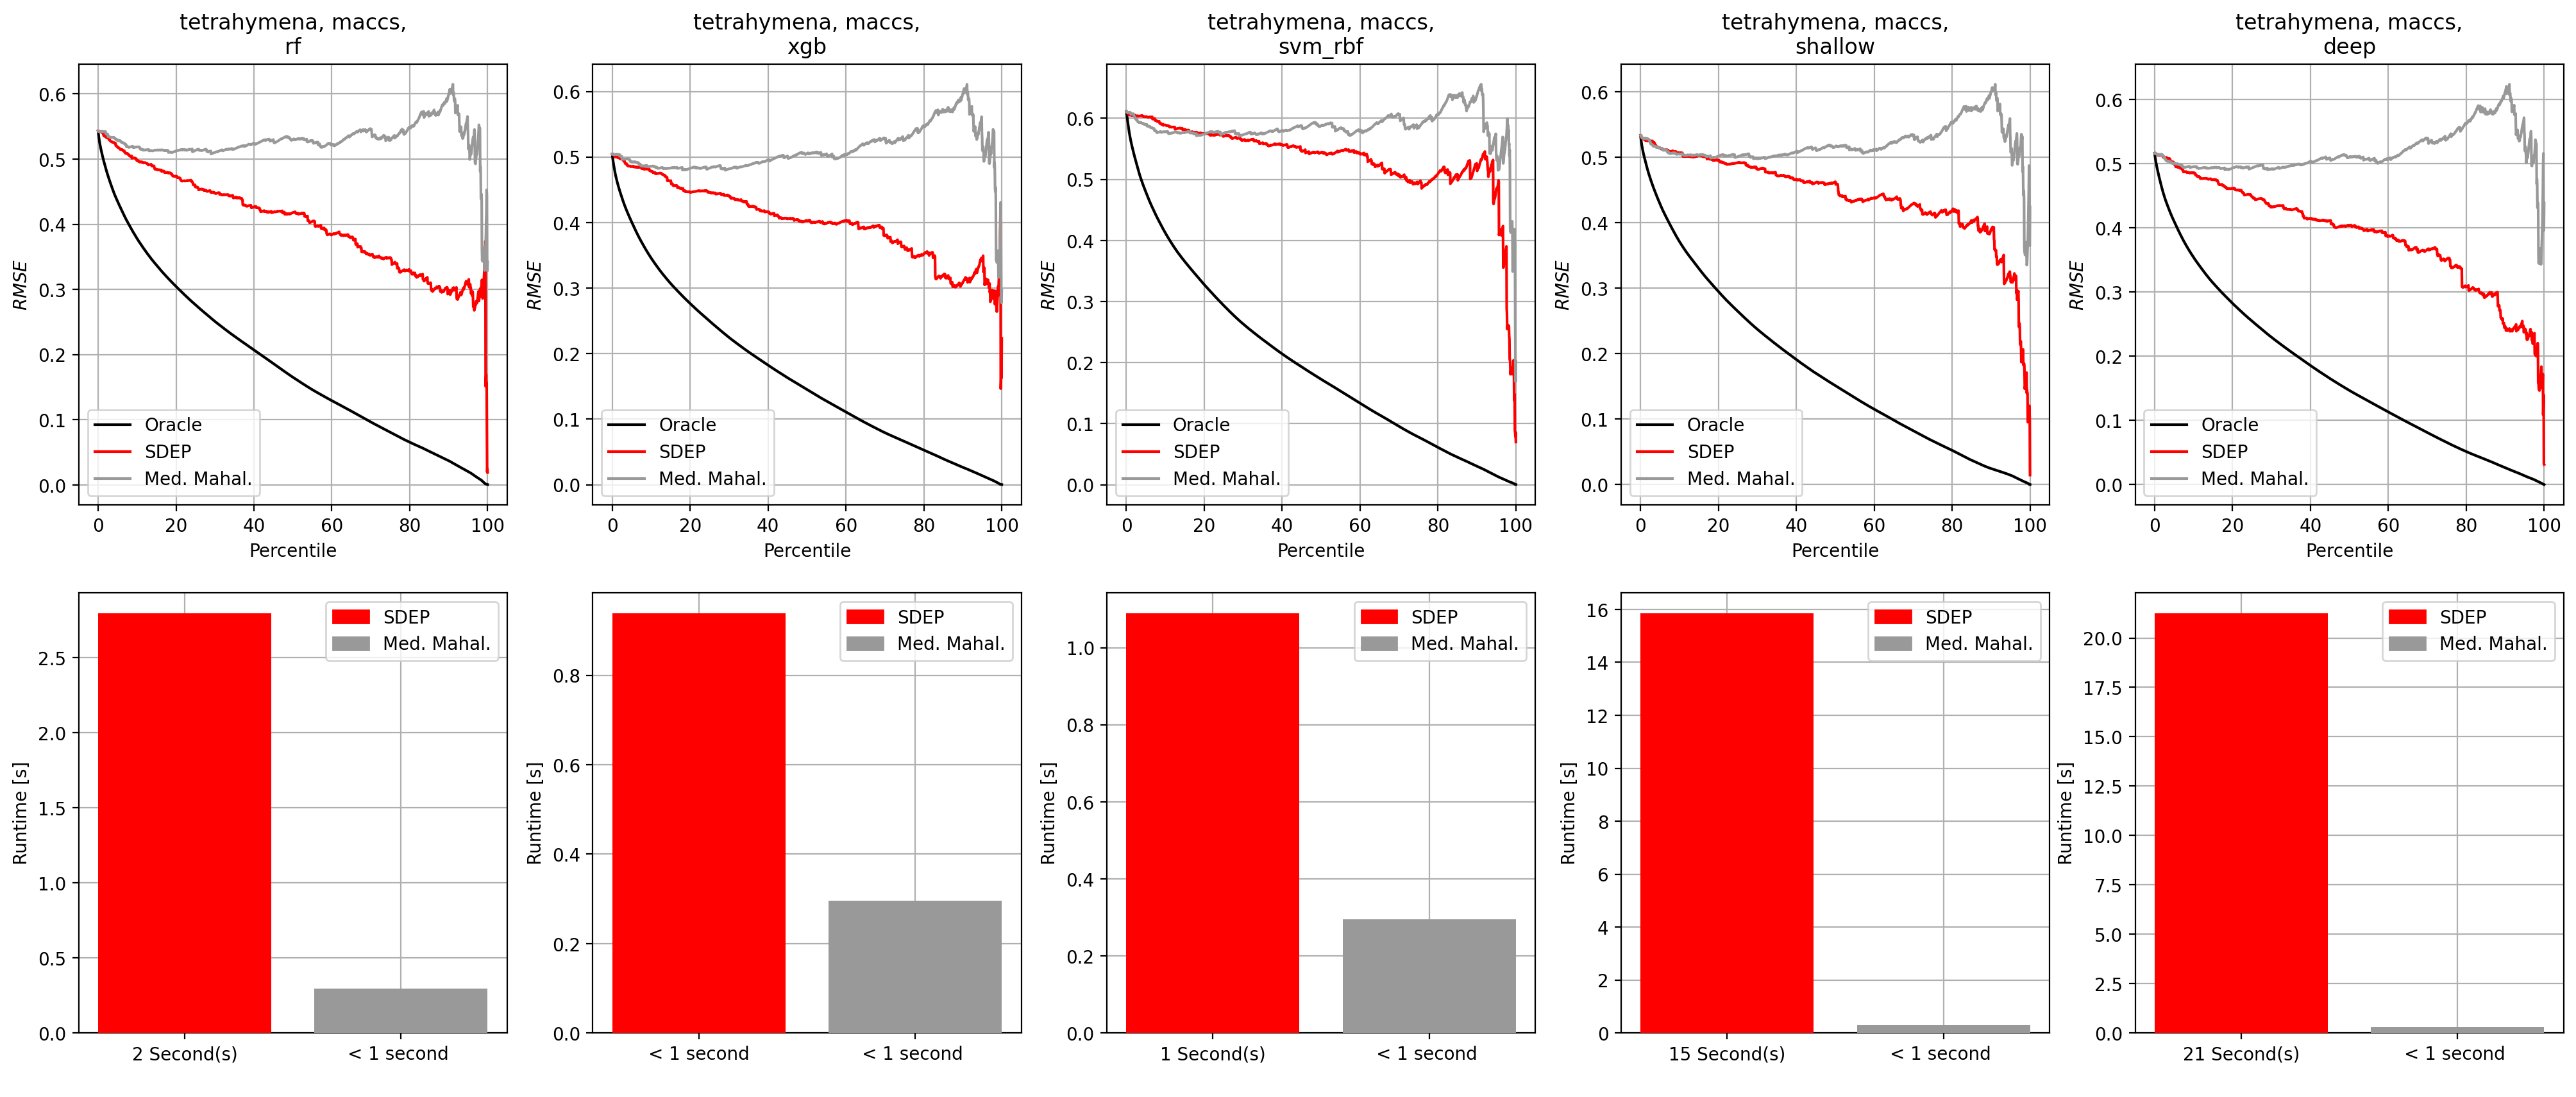

  4%|▍         | 4/100 [00:00<00:02, 37.98it/s]

Computing Mahalanobis distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  1%|          | 1/100 [00:00<00:18,  5.48it/s]

At xgb.


  0%|          | 0/100 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [07:08<00:00,  4.29s/it]


Plotting.


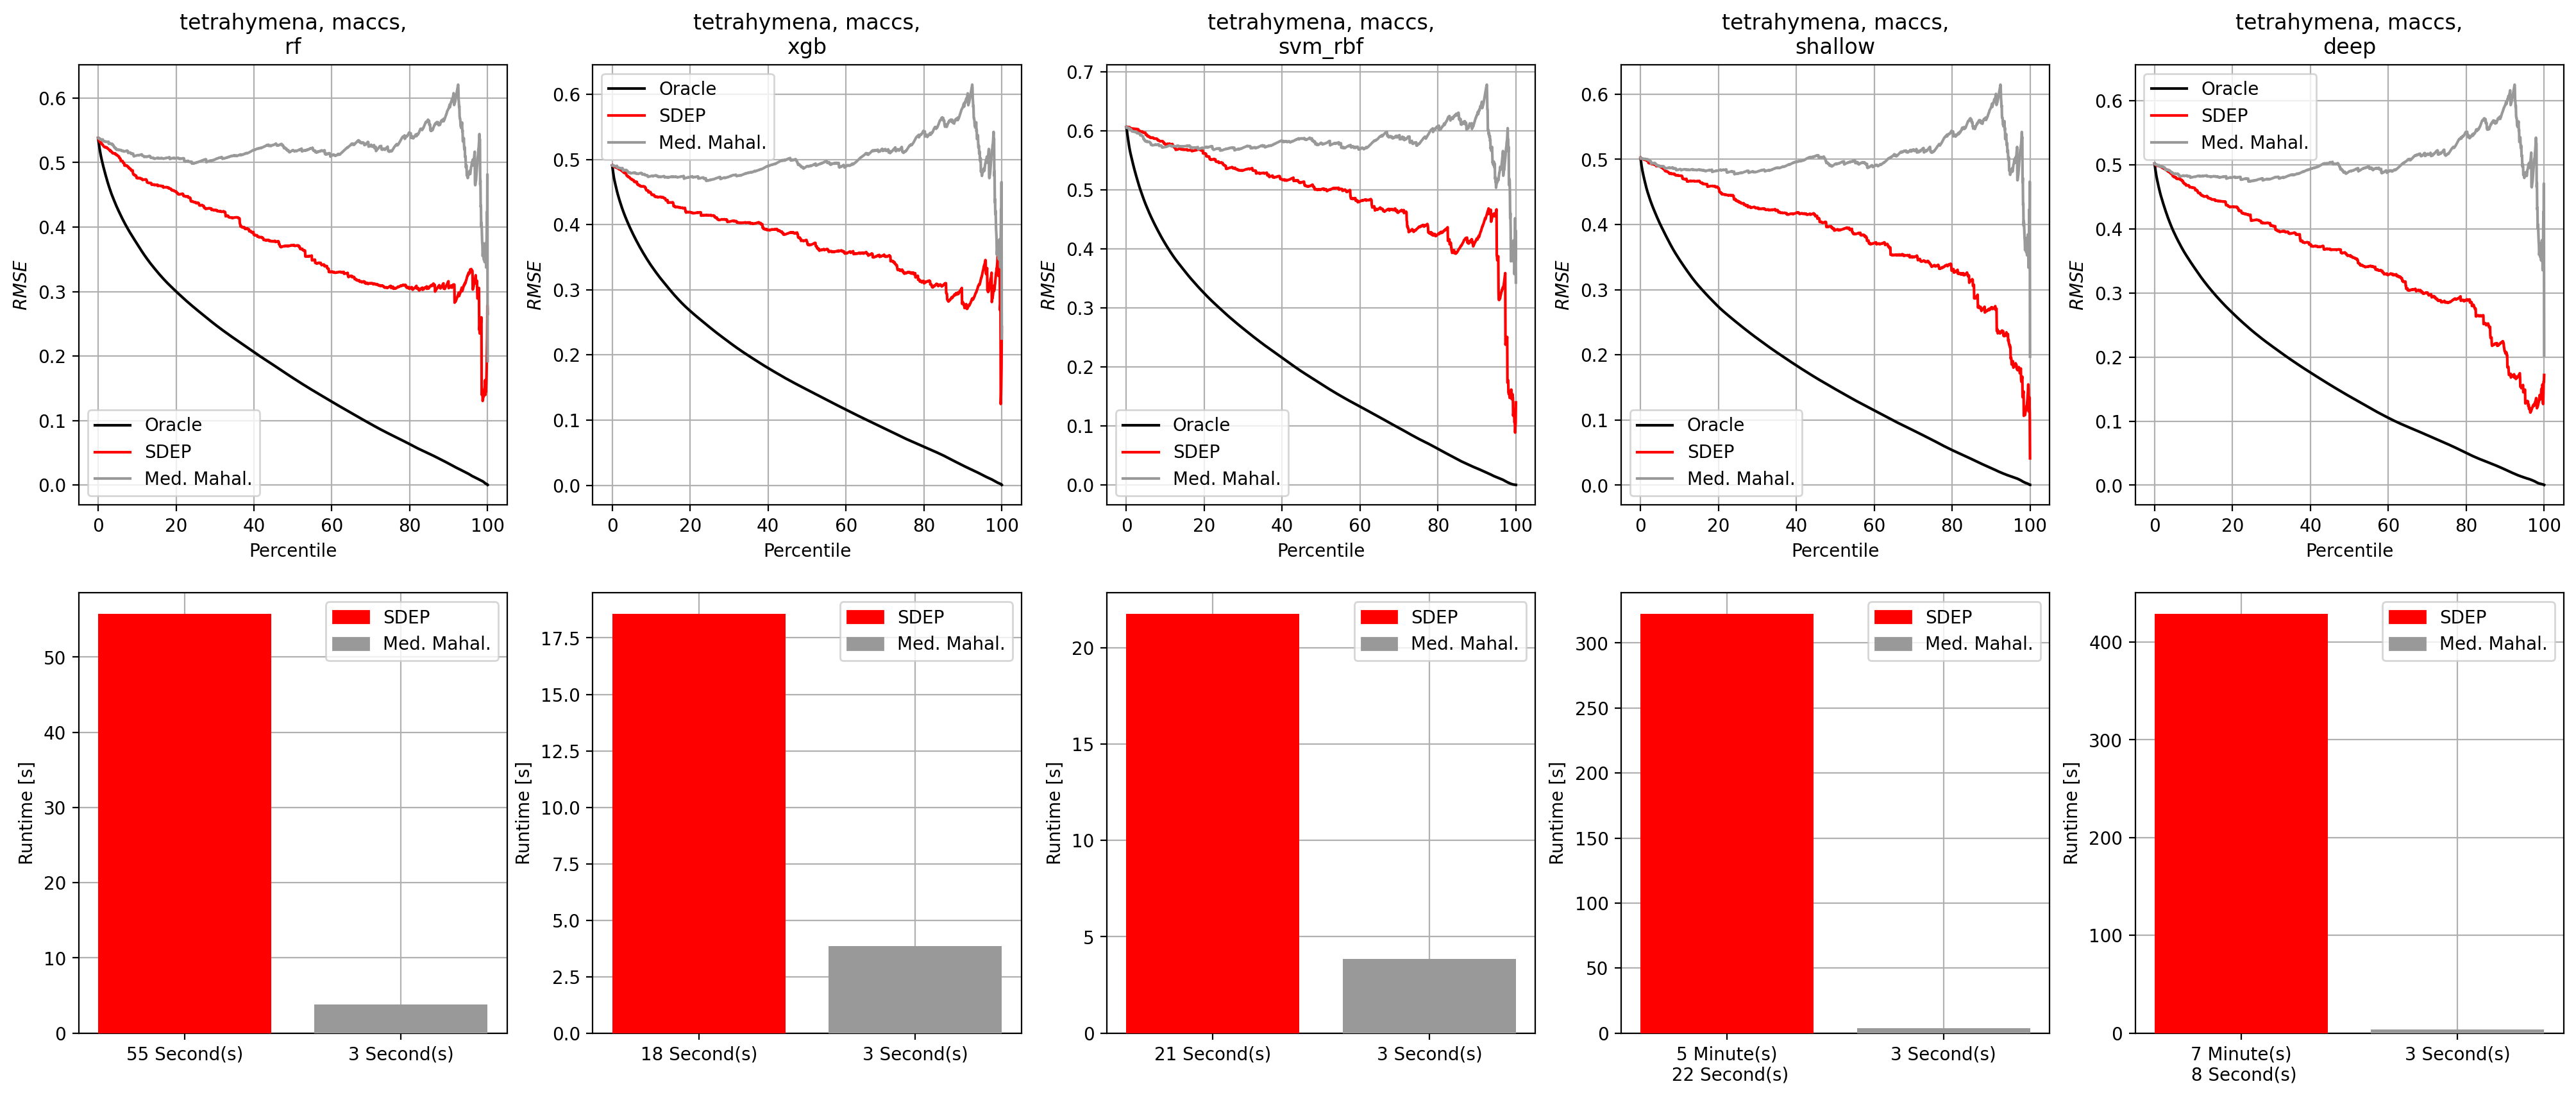

In [10]:
compare_median('tetrahymena', 'maccs', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('tetrahymena', 'maccs', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)

### Tetrahymena, ECFP, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]

Computing Mahalanobis distances.


  0%|          | 0/5 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/5 [00:00<?, ?it/s]

At xgb.


  0%|          | 0/5 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:23<00:00,  4.68s/it]


Plotting.


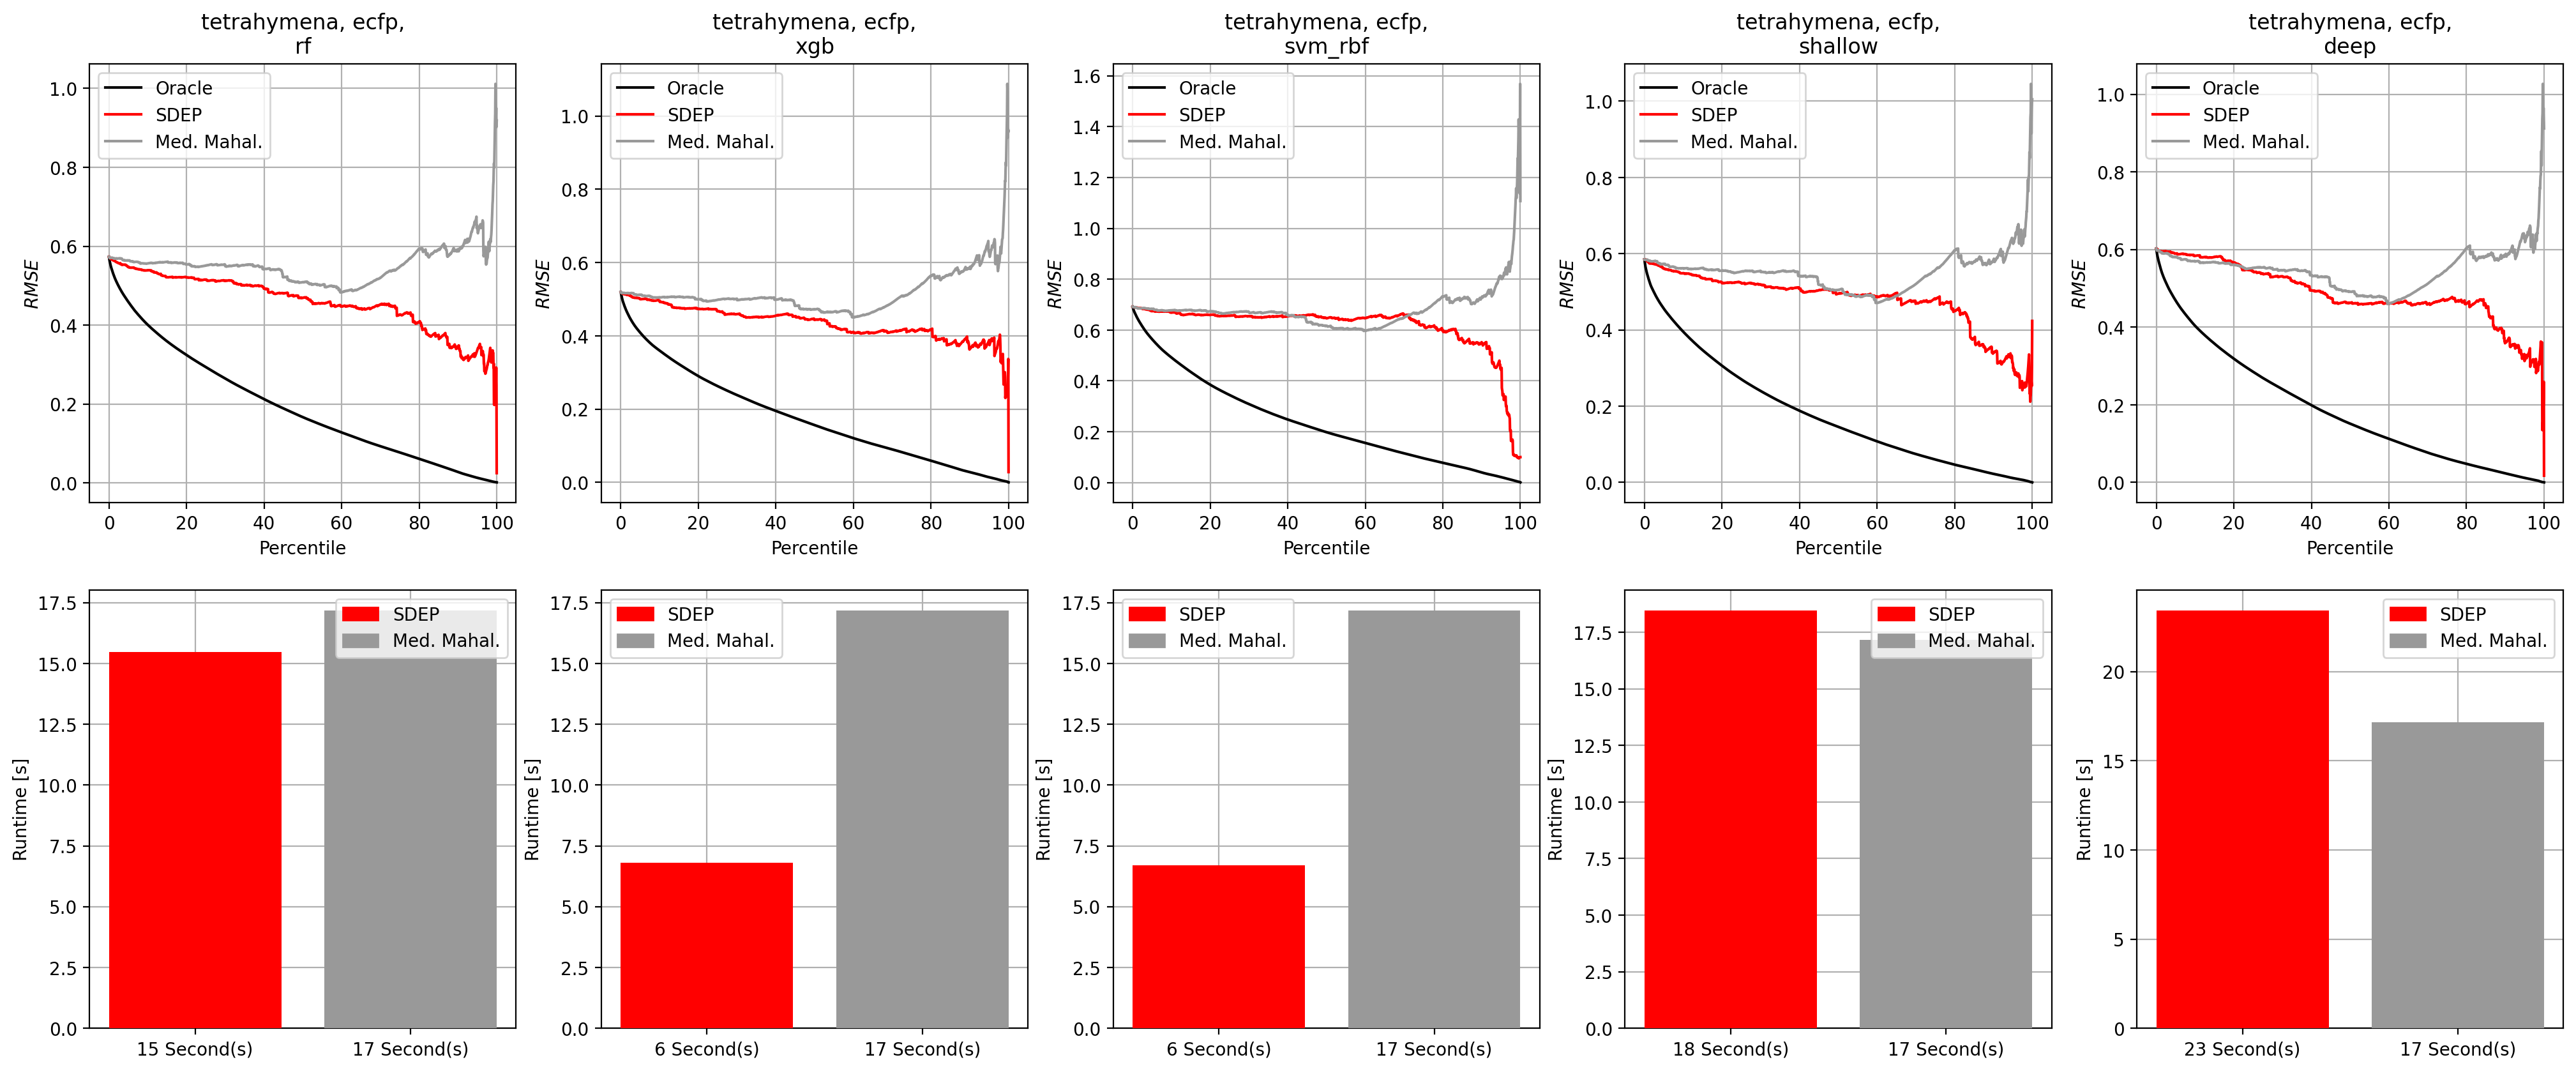

  0%|          | 0/100 [00:00<?, ?it/s]

Computing Mahalanobis distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/100 [00:00<?, ?it/s]

At xgb.


  0%|          | 0/100 [00:00<?, ?it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [07:56<00:00,  4.76s/it]


Plotting.


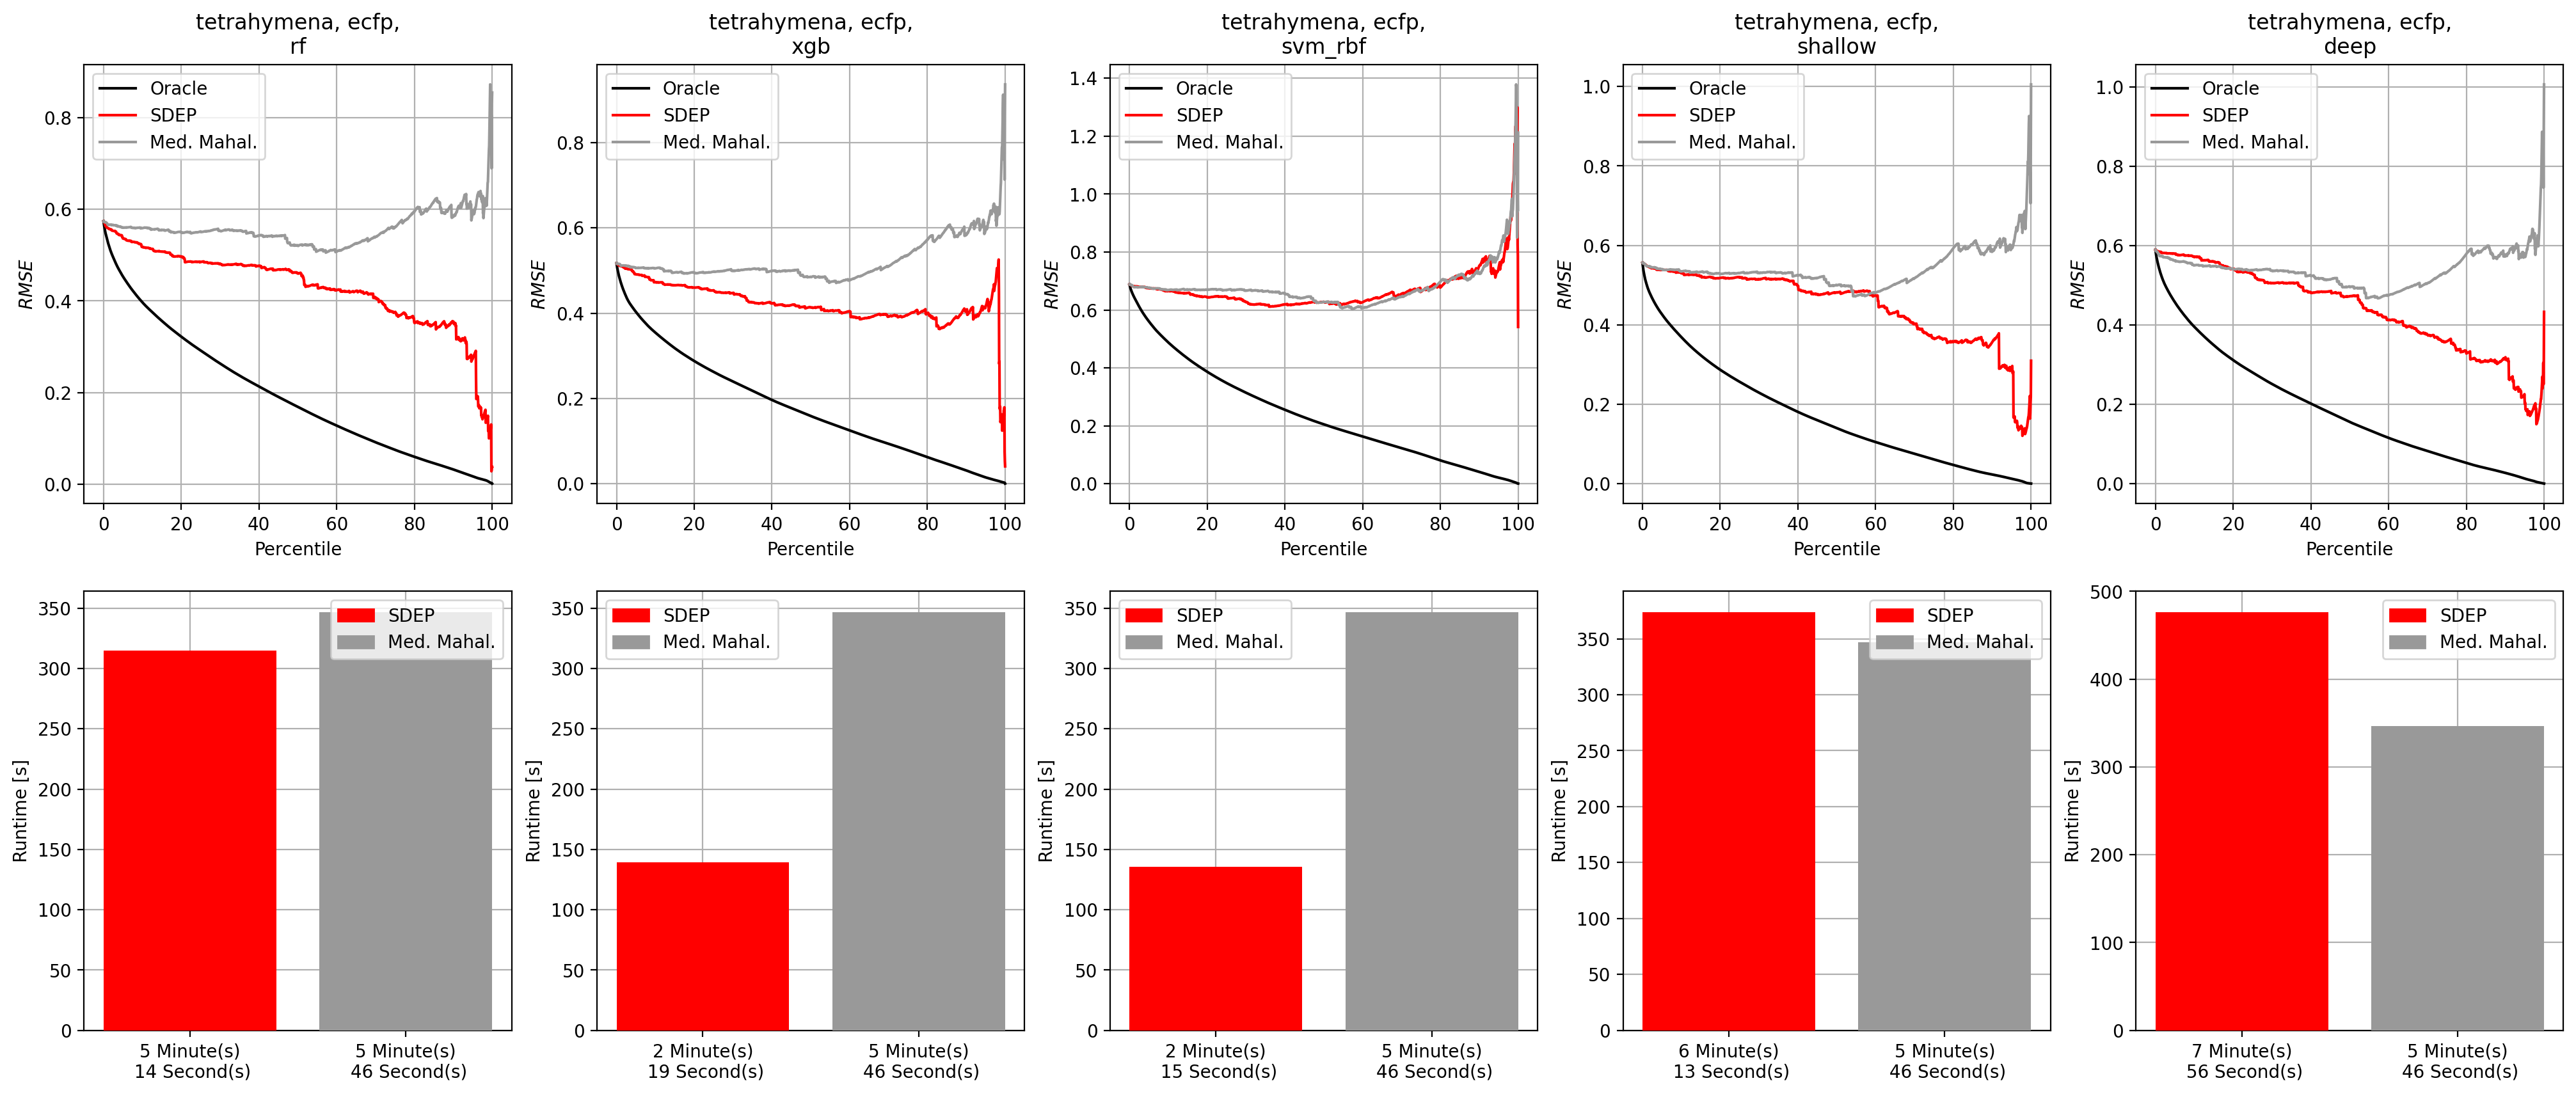

In [11]:
compare_median('tetrahymena', 'ecfp', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('tetrahymena', 'ecfp', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)

### FreeSolv, RDKit descriptors, large-scale evaluation

100%|██████████| 5/5 [00:00<00:00, 29.90it/s]

Computing Mahalanobis distances.
Running evaluators.



  0%|          | 0/5 [00:00<?, ?it/s]

At rf.


 20%|██        | 1/5 [00:00<00:00,  5.17it/s]

At xgb.


 40%|████      | 2/5 [00:00<00:00, 16.65it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


Plotting.


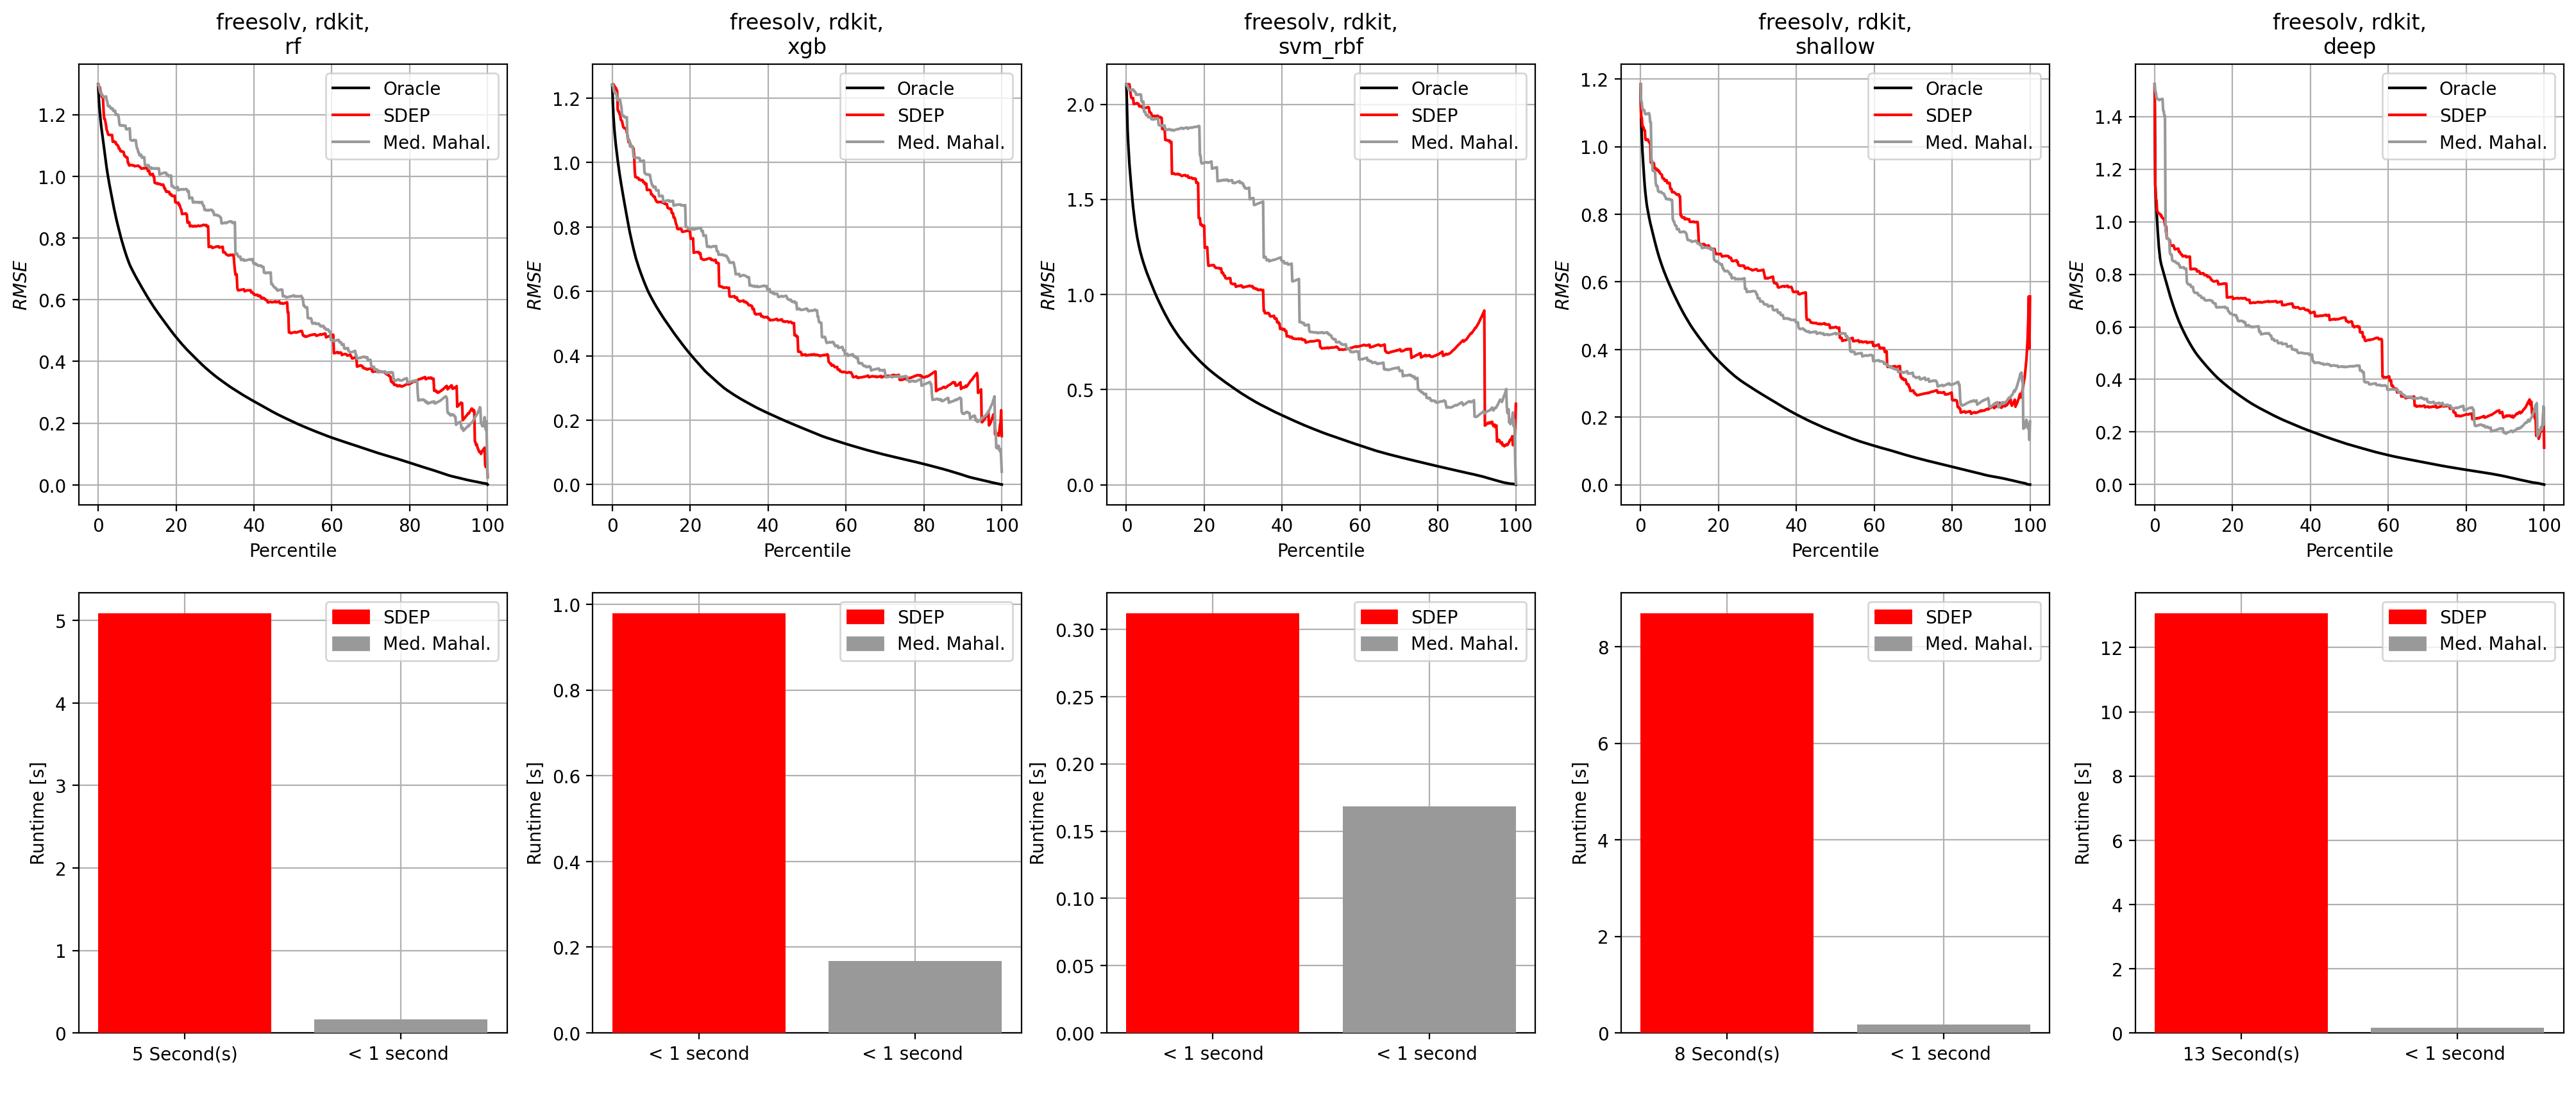

  5%|▌         | 5/100 [00:00<00:02, 41.73it/s]

Computing Mahalanobis distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/100 [00:00<?, ?it/s]

At xgb.


  2%|▏         | 2/100 [00:00<00:06, 16.08it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [03:52<00:00,  2.32s/it]


Plotting.


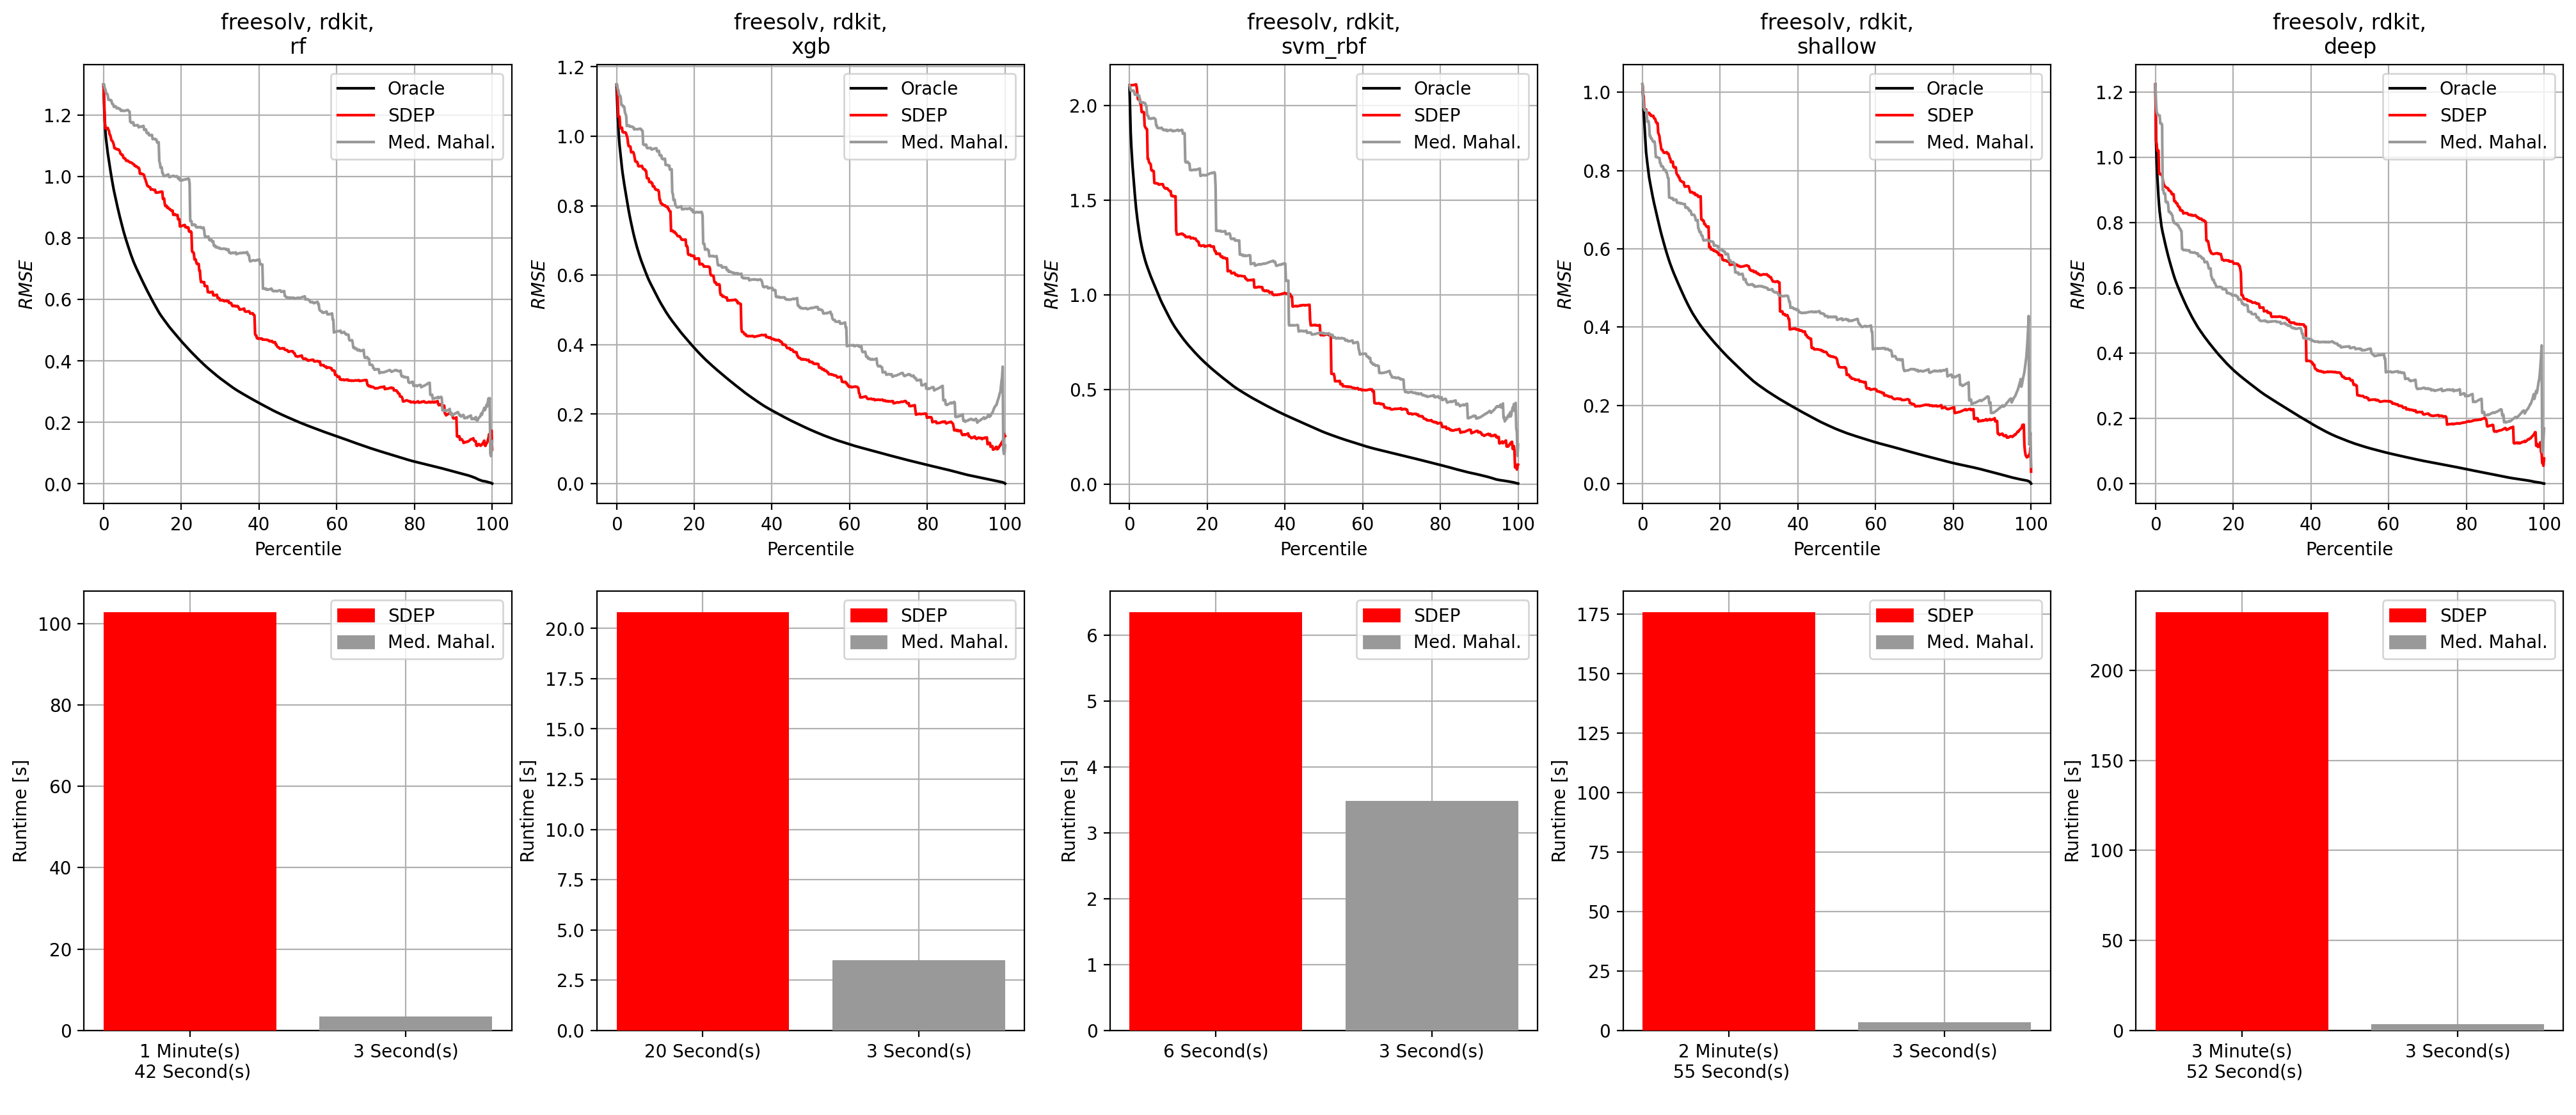

In [12]:
compare_median('freesolv', 'rdkit', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('freesolv', 'rdkit', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)

### FreeSolv, CDDD, large-scale evaluation

 20%|██        | 1/5 [00:00<00:00,  5.56it/s]

Computing Mahalanobis distances.


  0%|          | 0/5 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/5 [00:00<?, ?it/s]

At xgb.


 20%|██        | 1/5 [00:00<00:00,  8.68it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


Plotting.


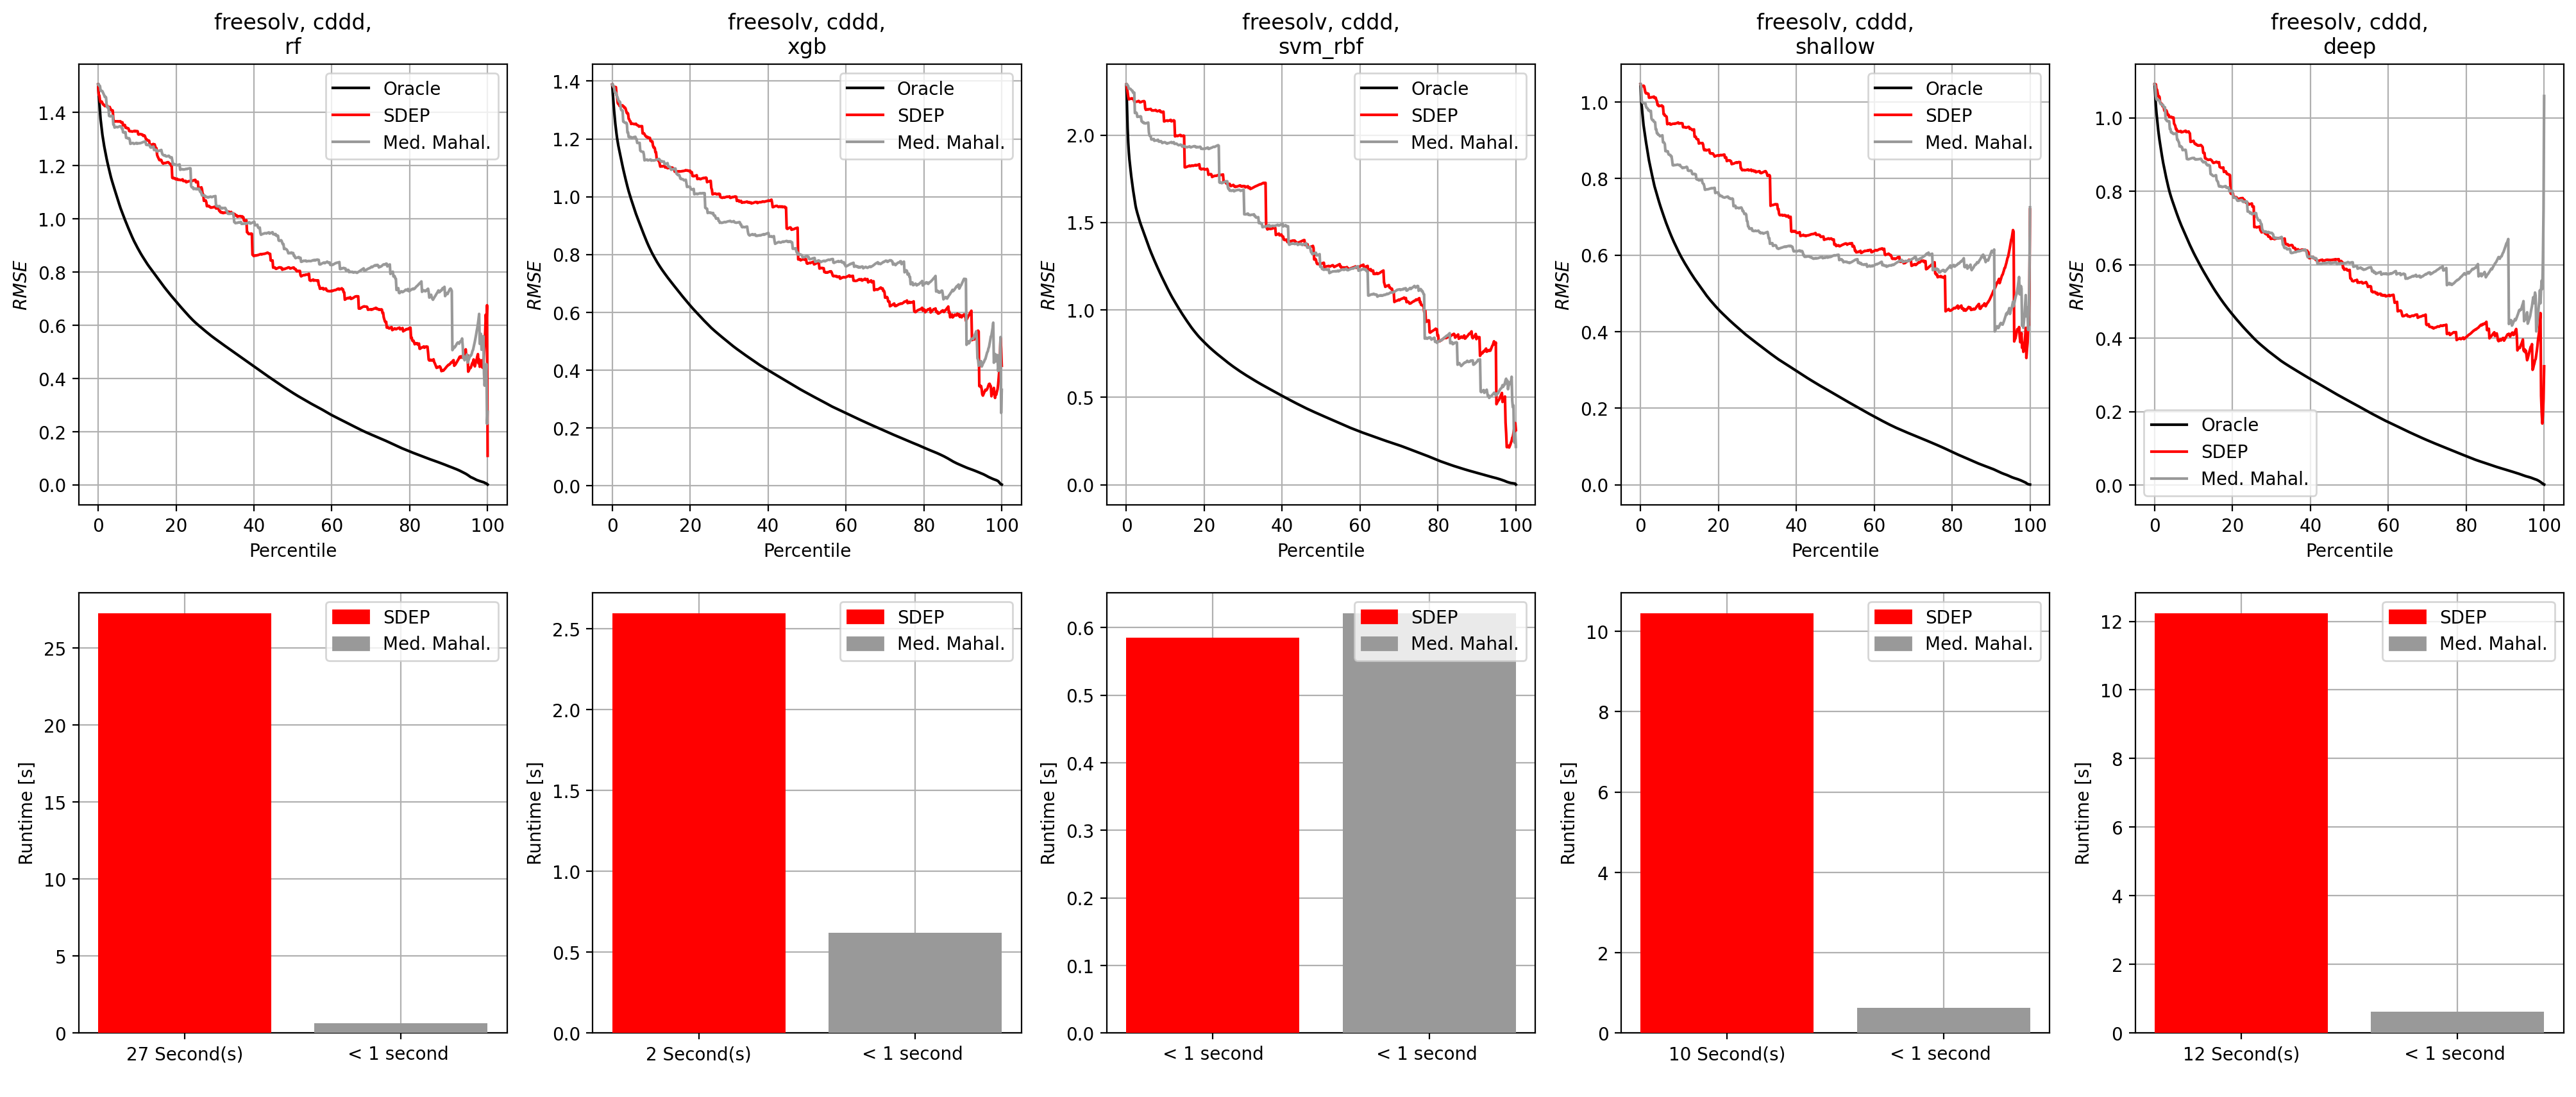

  1%|          | 1/100 [00:00<00:15,  6.54it/s]

Computing Mahalanobis distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/100 [00:00<?, ?it/s]

At xgb.


  1%|          | 1/100 [00:00<00:11,  8.63it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [03:58<00:00,  2.39s/it]


Plotting.


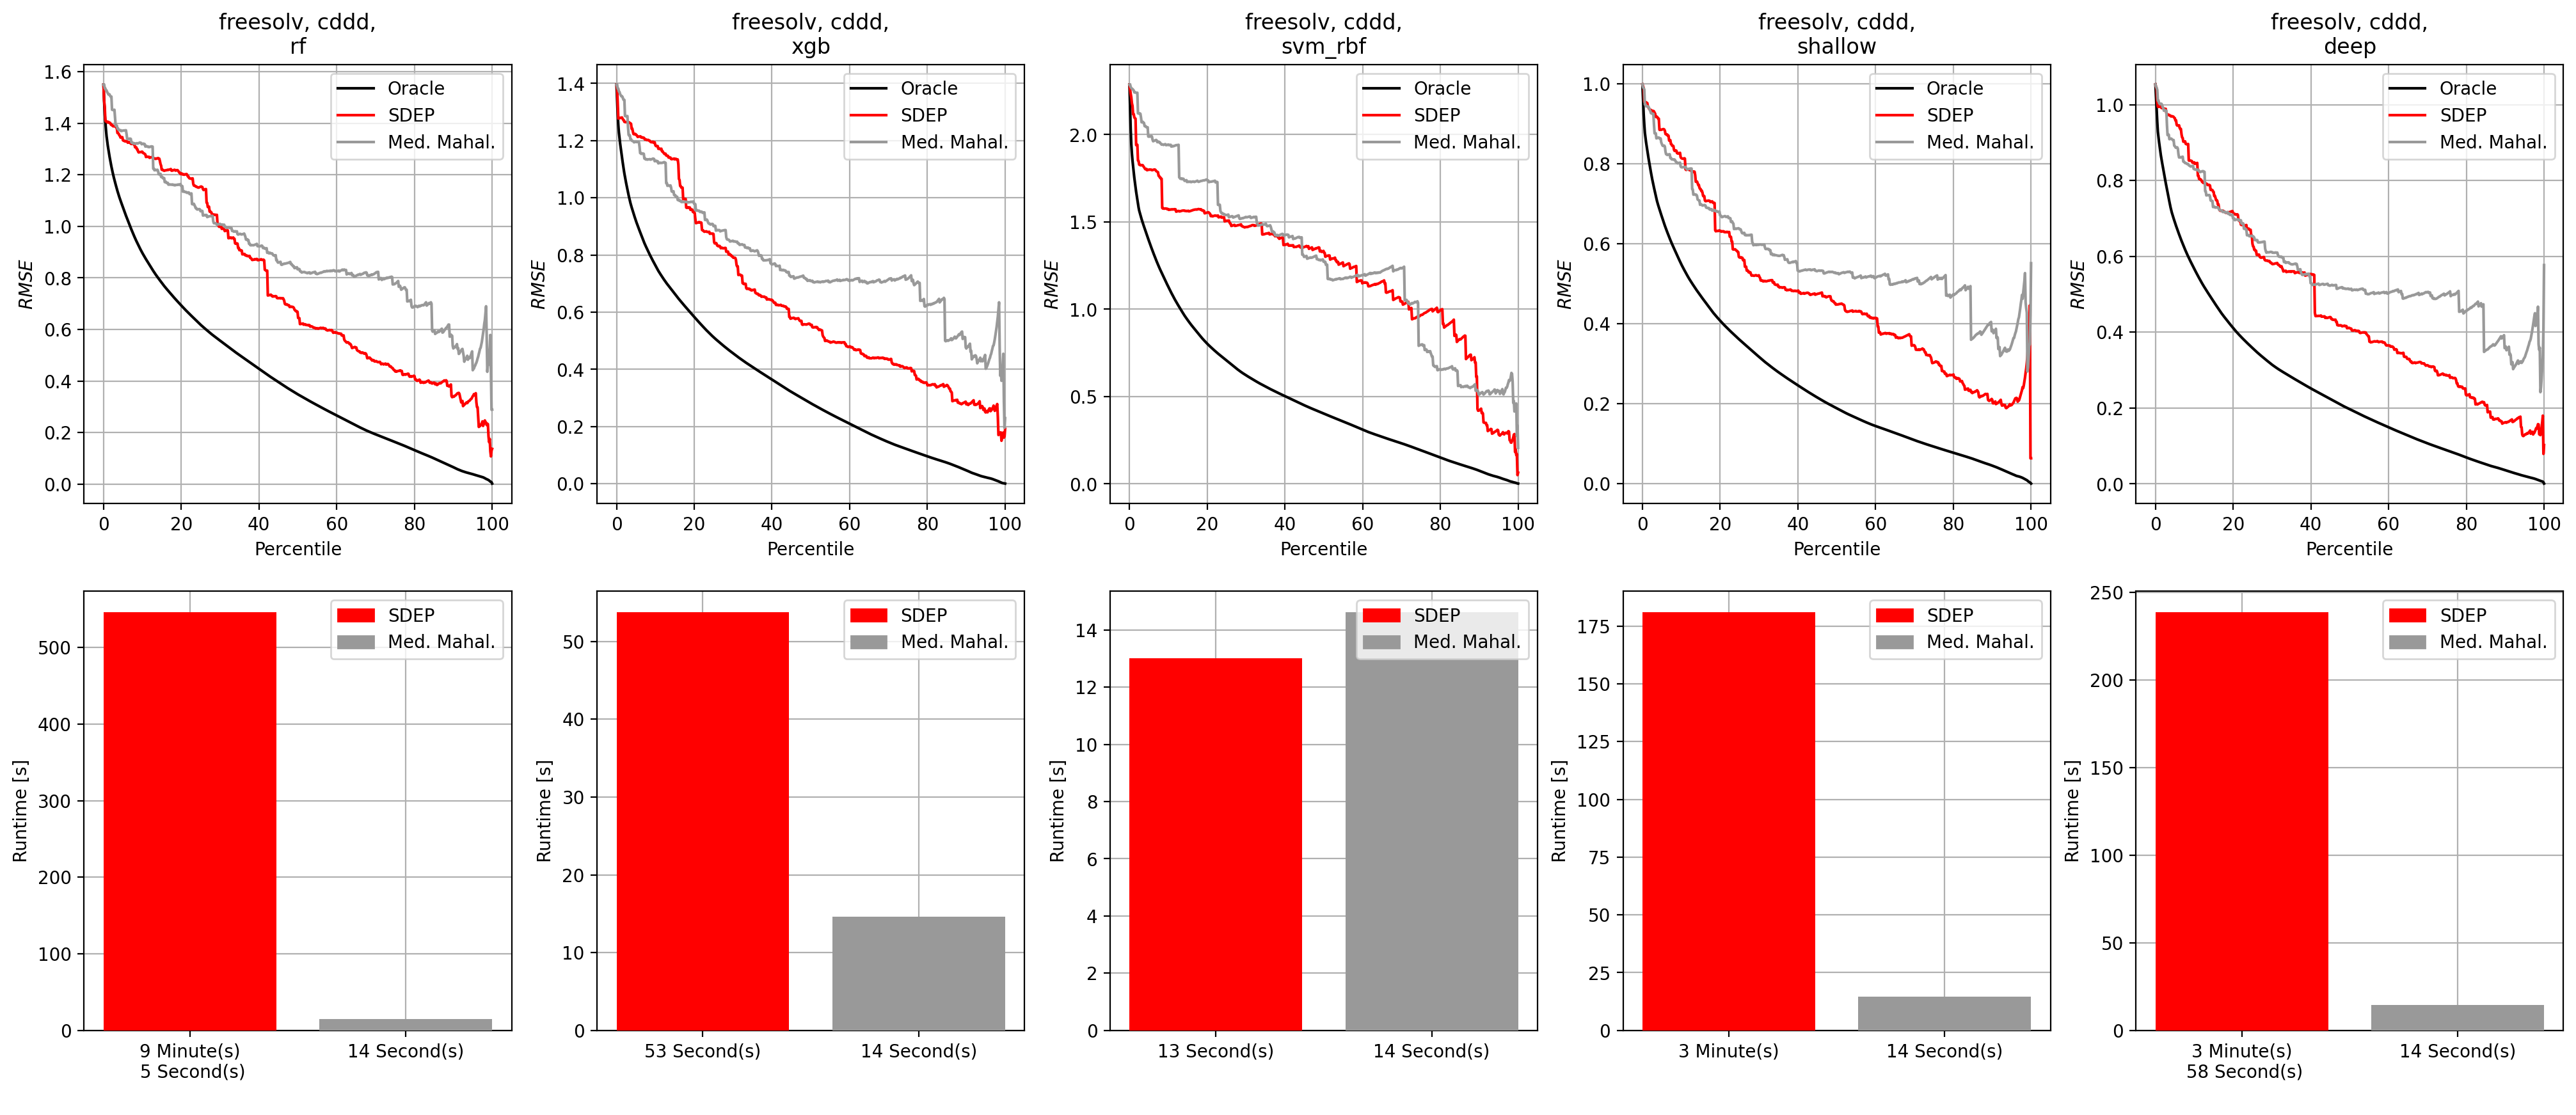

In [13]:
compare_median('freesolv', 'cddd', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('freesolv', 'cddd', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)

### IL4, RDKit descriptors, large-scale evaluation

100%|██████████| 5/5 [00:00<00:00, 42.27it/s]

Computing Mahalanobis distances.
Running evaluators.



  0%|          | 0/5 [00:00<?, ?it/s]

At rf.


  0%|          | 0/5 [00:00<?, ?it/s]

At xgb.


 40%|████      | 2/5 [00:00<00:00, 18.38it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Plotting.


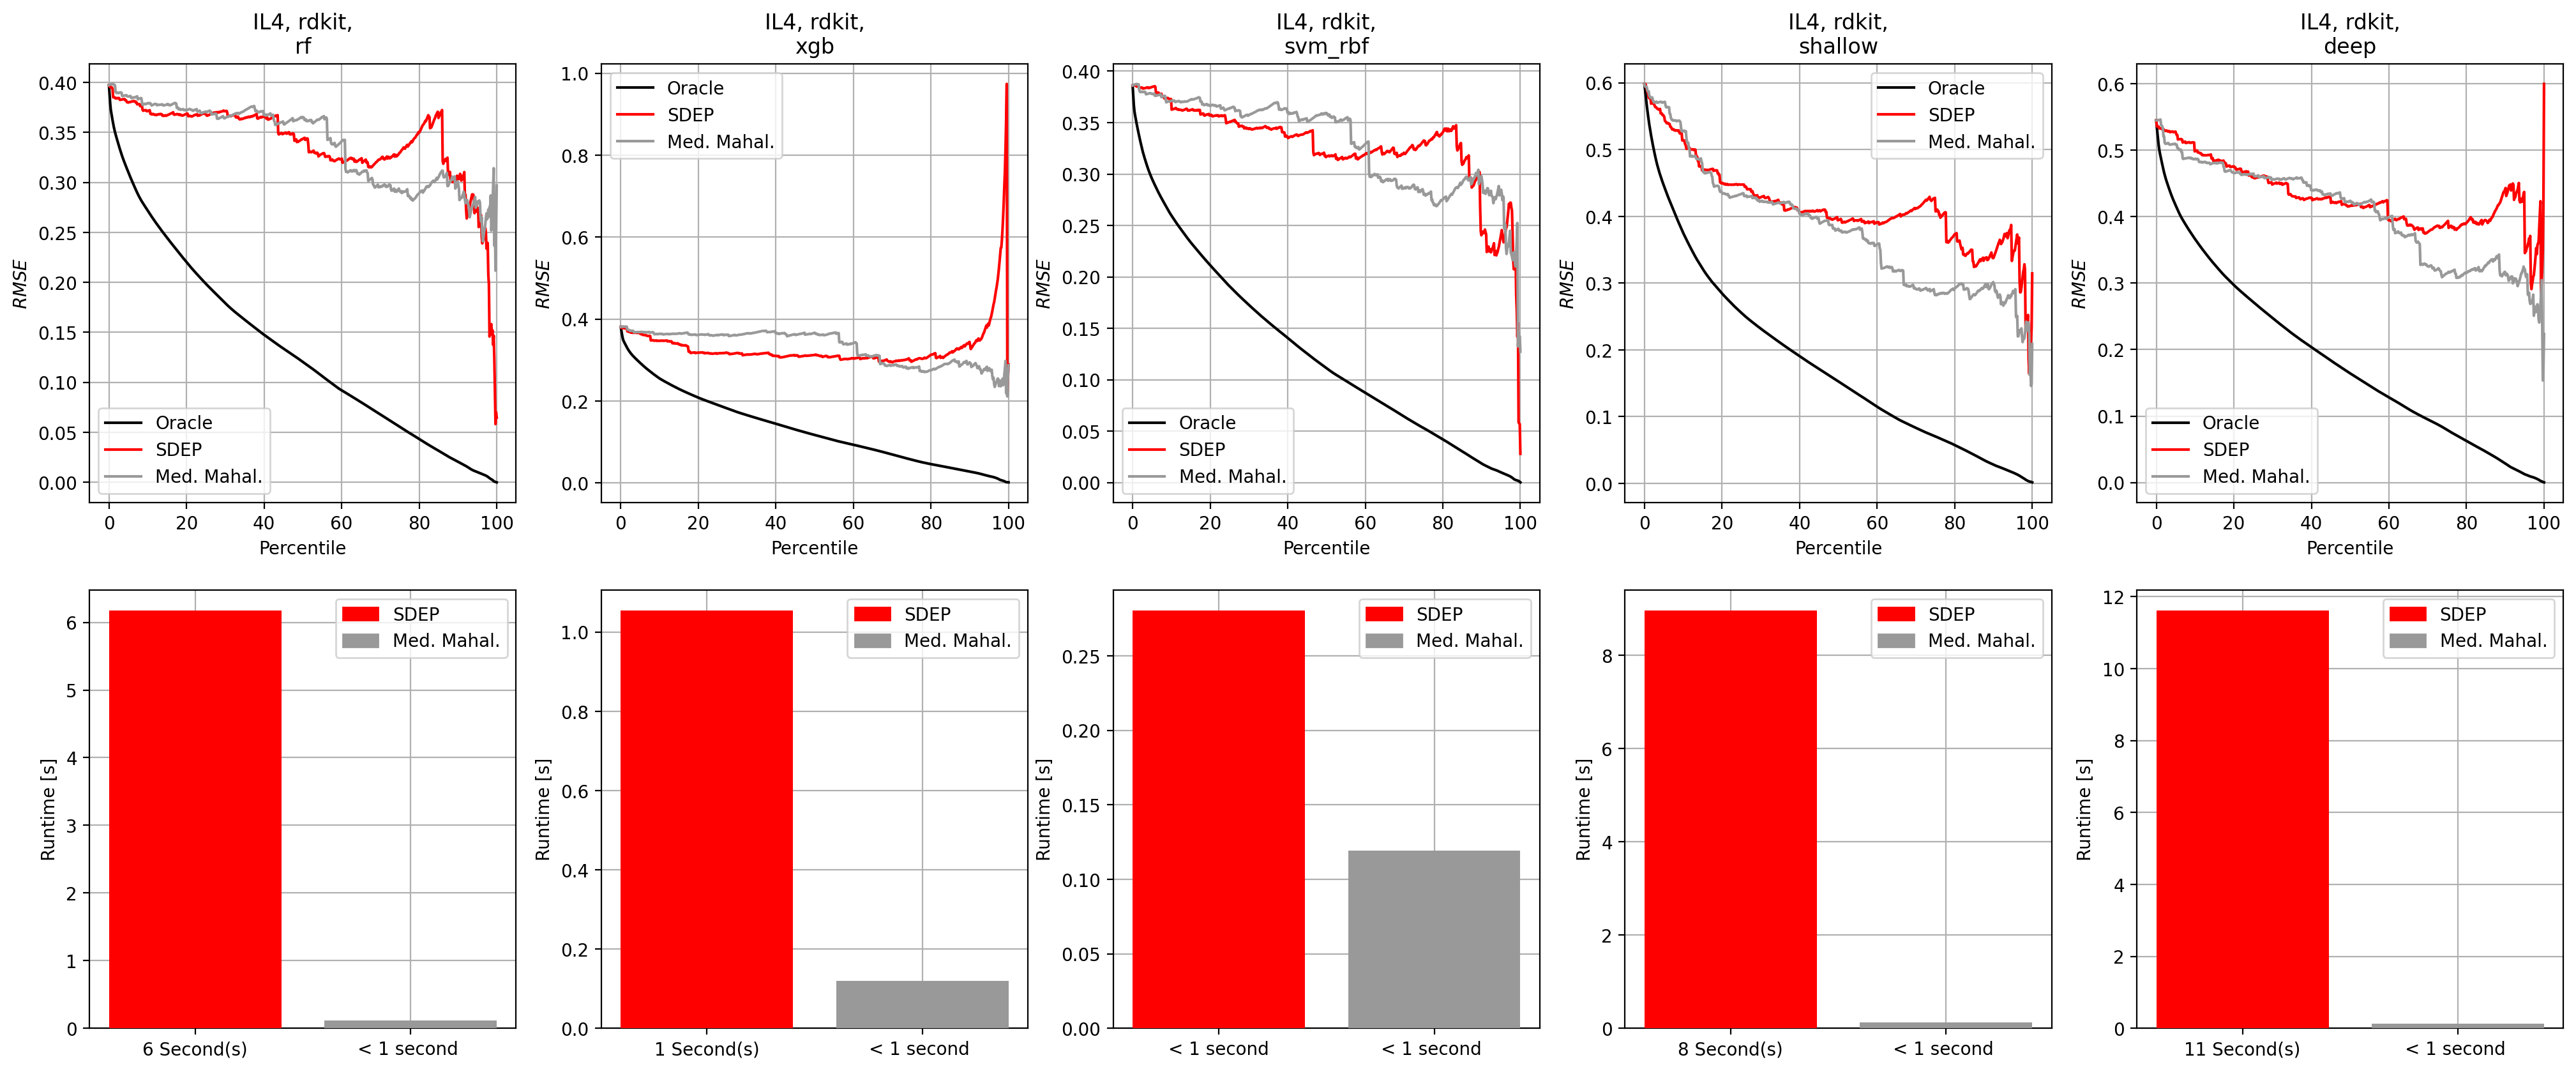

  3%|▎         | 3/100 [00:00<00:04, 22.05it/s]

Computing Mahalanobis distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/100 [00:00<?, ?it/s]

At xgb.


  2%|▏         | 2/100 [00:00<00:05, 17.83it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [03:52<00:00,  2.33s/it]


Plotting.


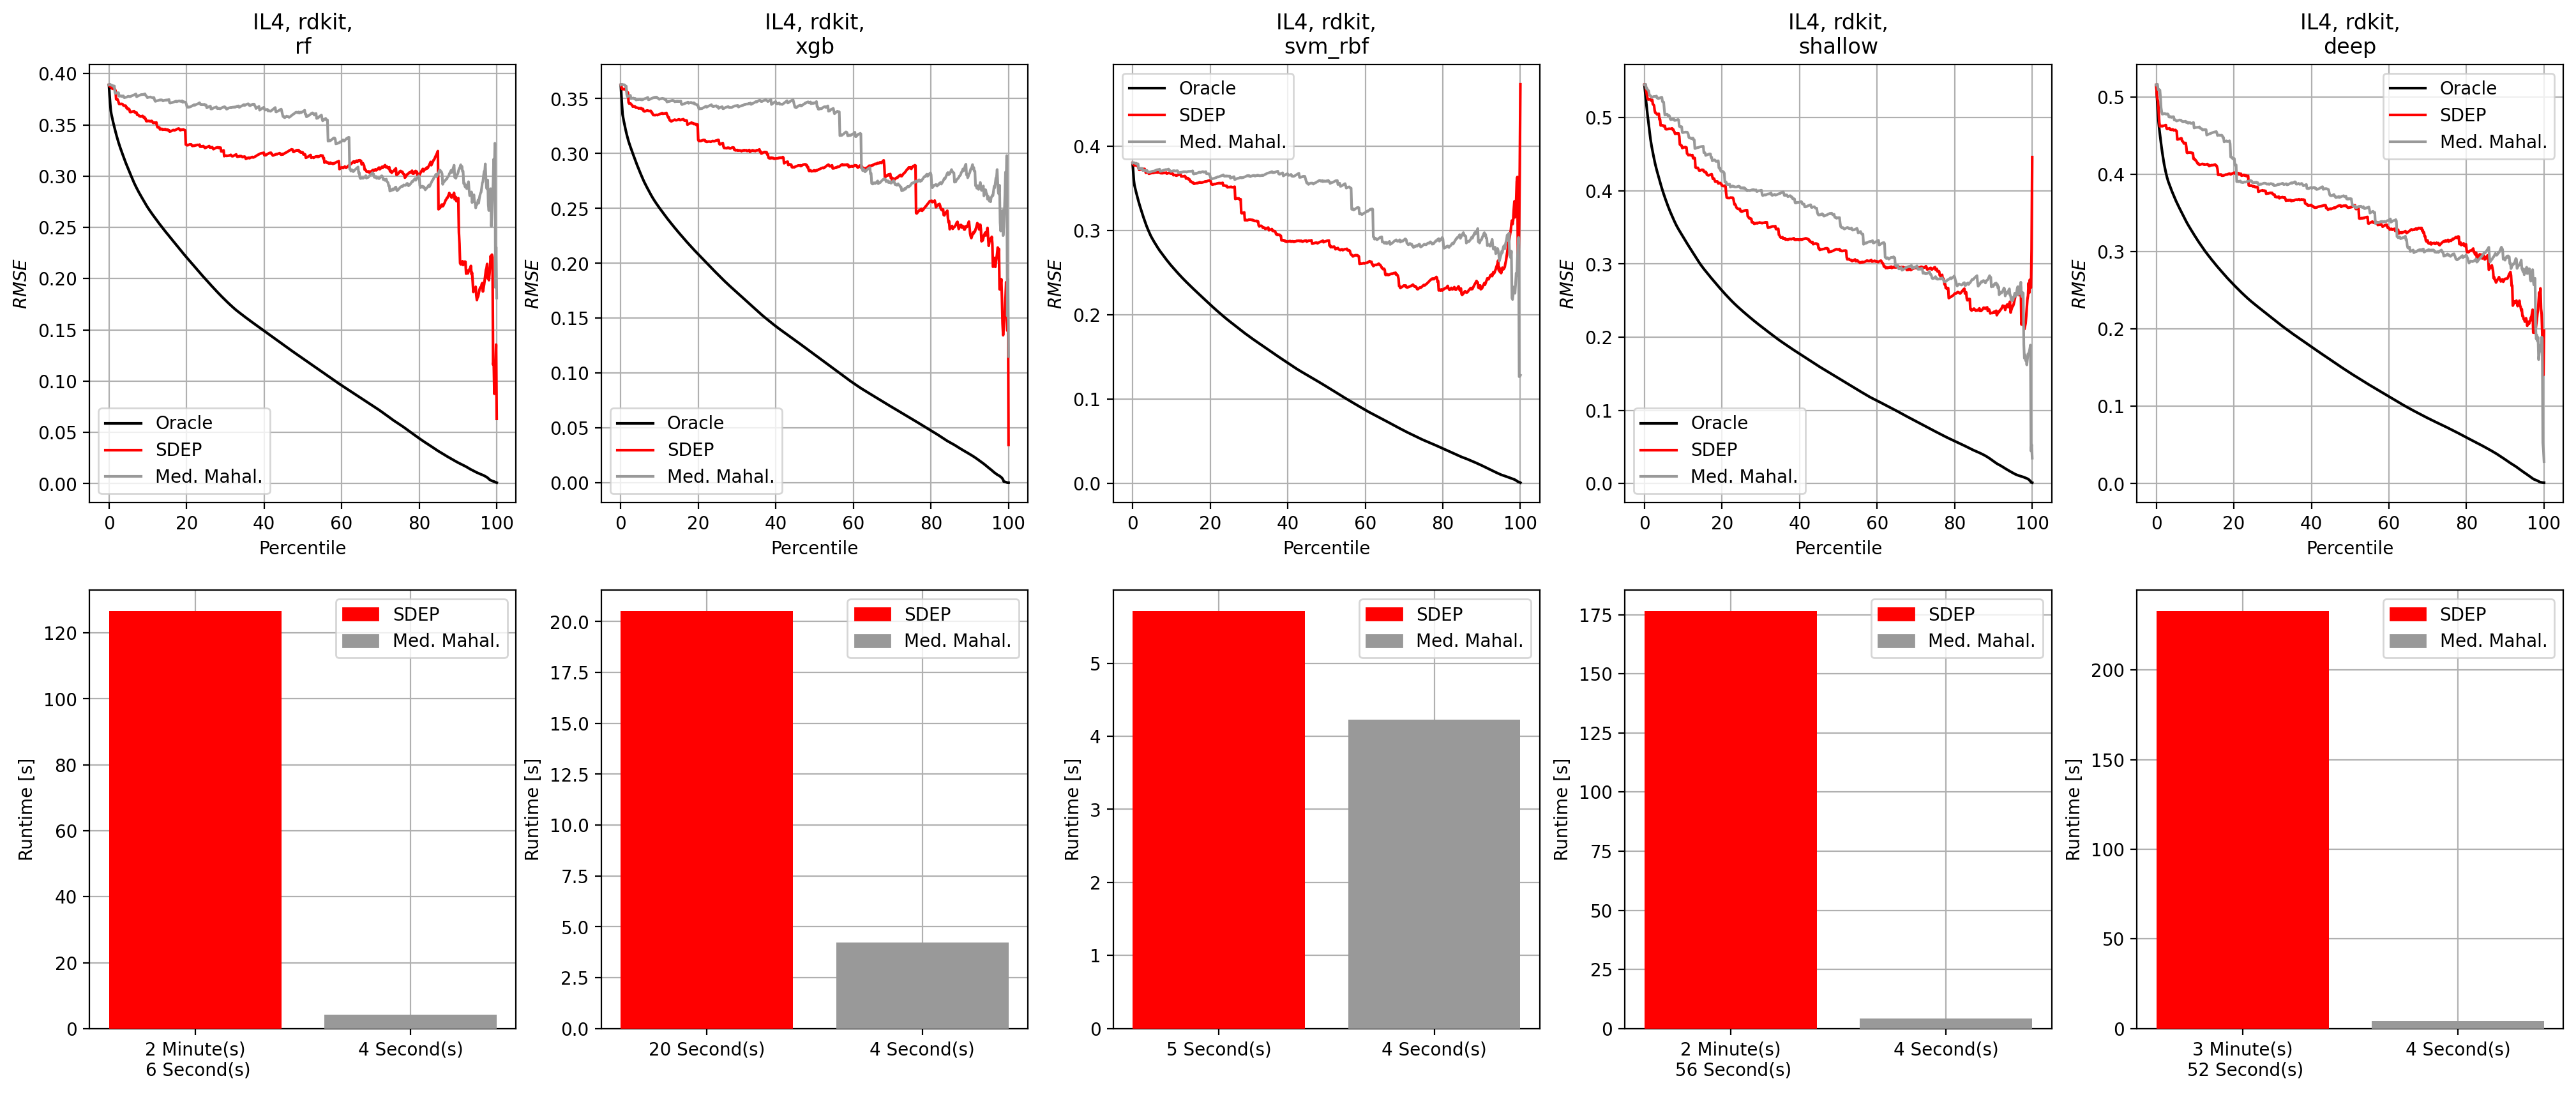

In [14]:
compare_median('IL4', 'rdkit', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('IL4', 'rdkit', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)

### IL4, CDDD, large-scale evaluation

 20%|██        | 1/5 [00:00<00:00,  5.12it/s]

Computing Mahalanobis distances.


  0%|          | 0/5 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/5 [00:00<?, ?it/s]

At xgb.


 20%|██        | 1/5 [00:00<00:00,  9.88it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Plotting.


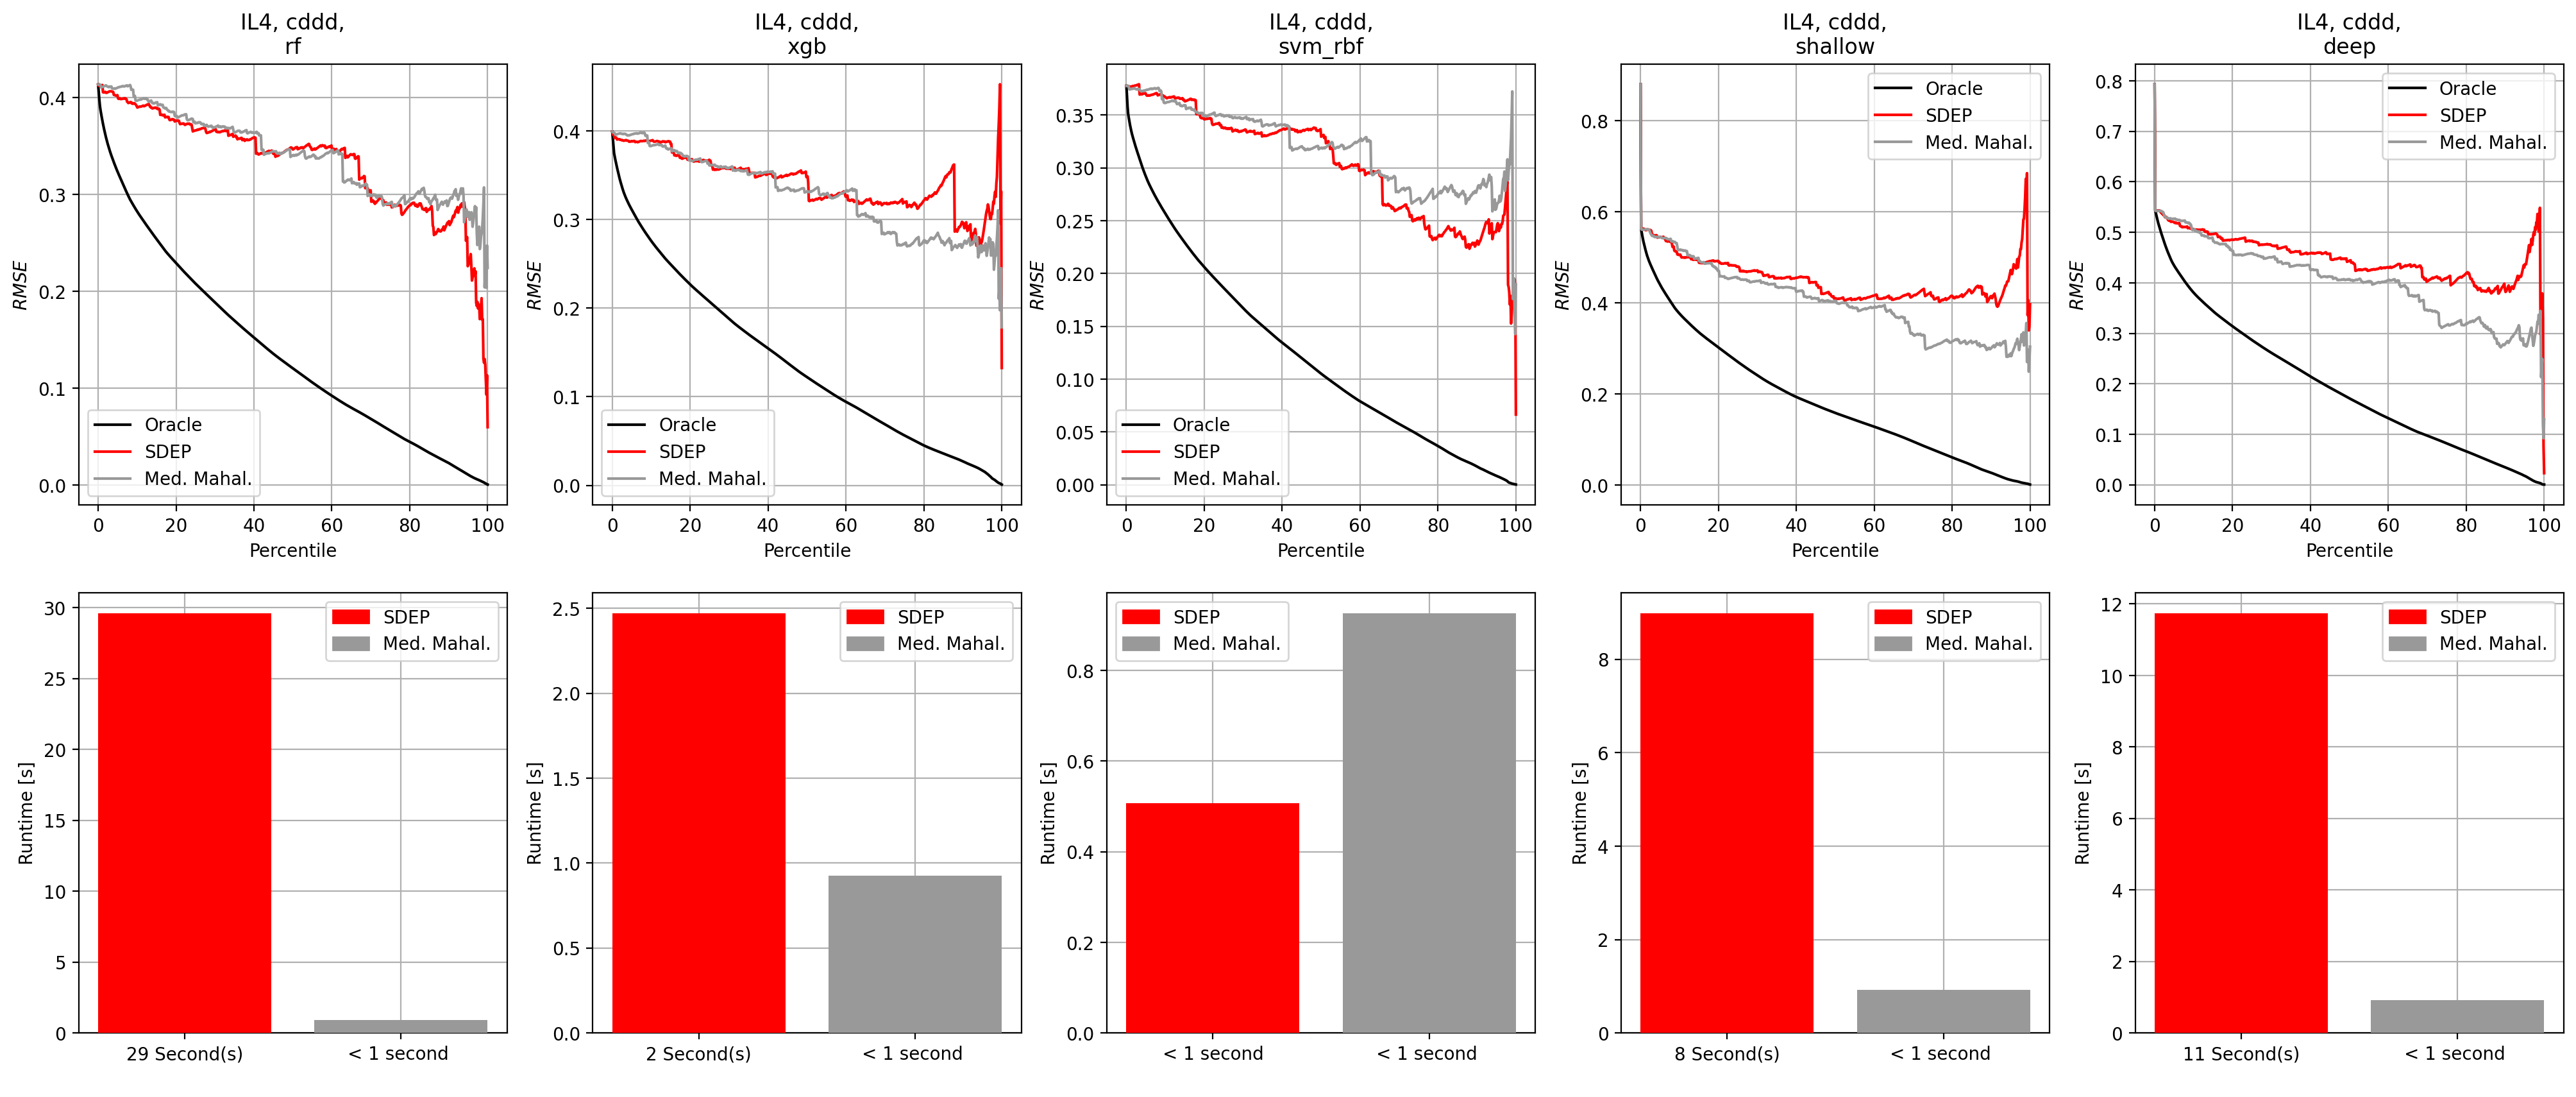

  0%|          | 0/100 [00:00<?, ?it/s]

Computing Mahalanobis distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  0%|          | 0/100 [00:00<?, ?it/s]

At xgb.


  1%|          | 1/100 [00:00<00:09,  9.94it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [03:59<00:00,  2.39s/it]


Plotting.


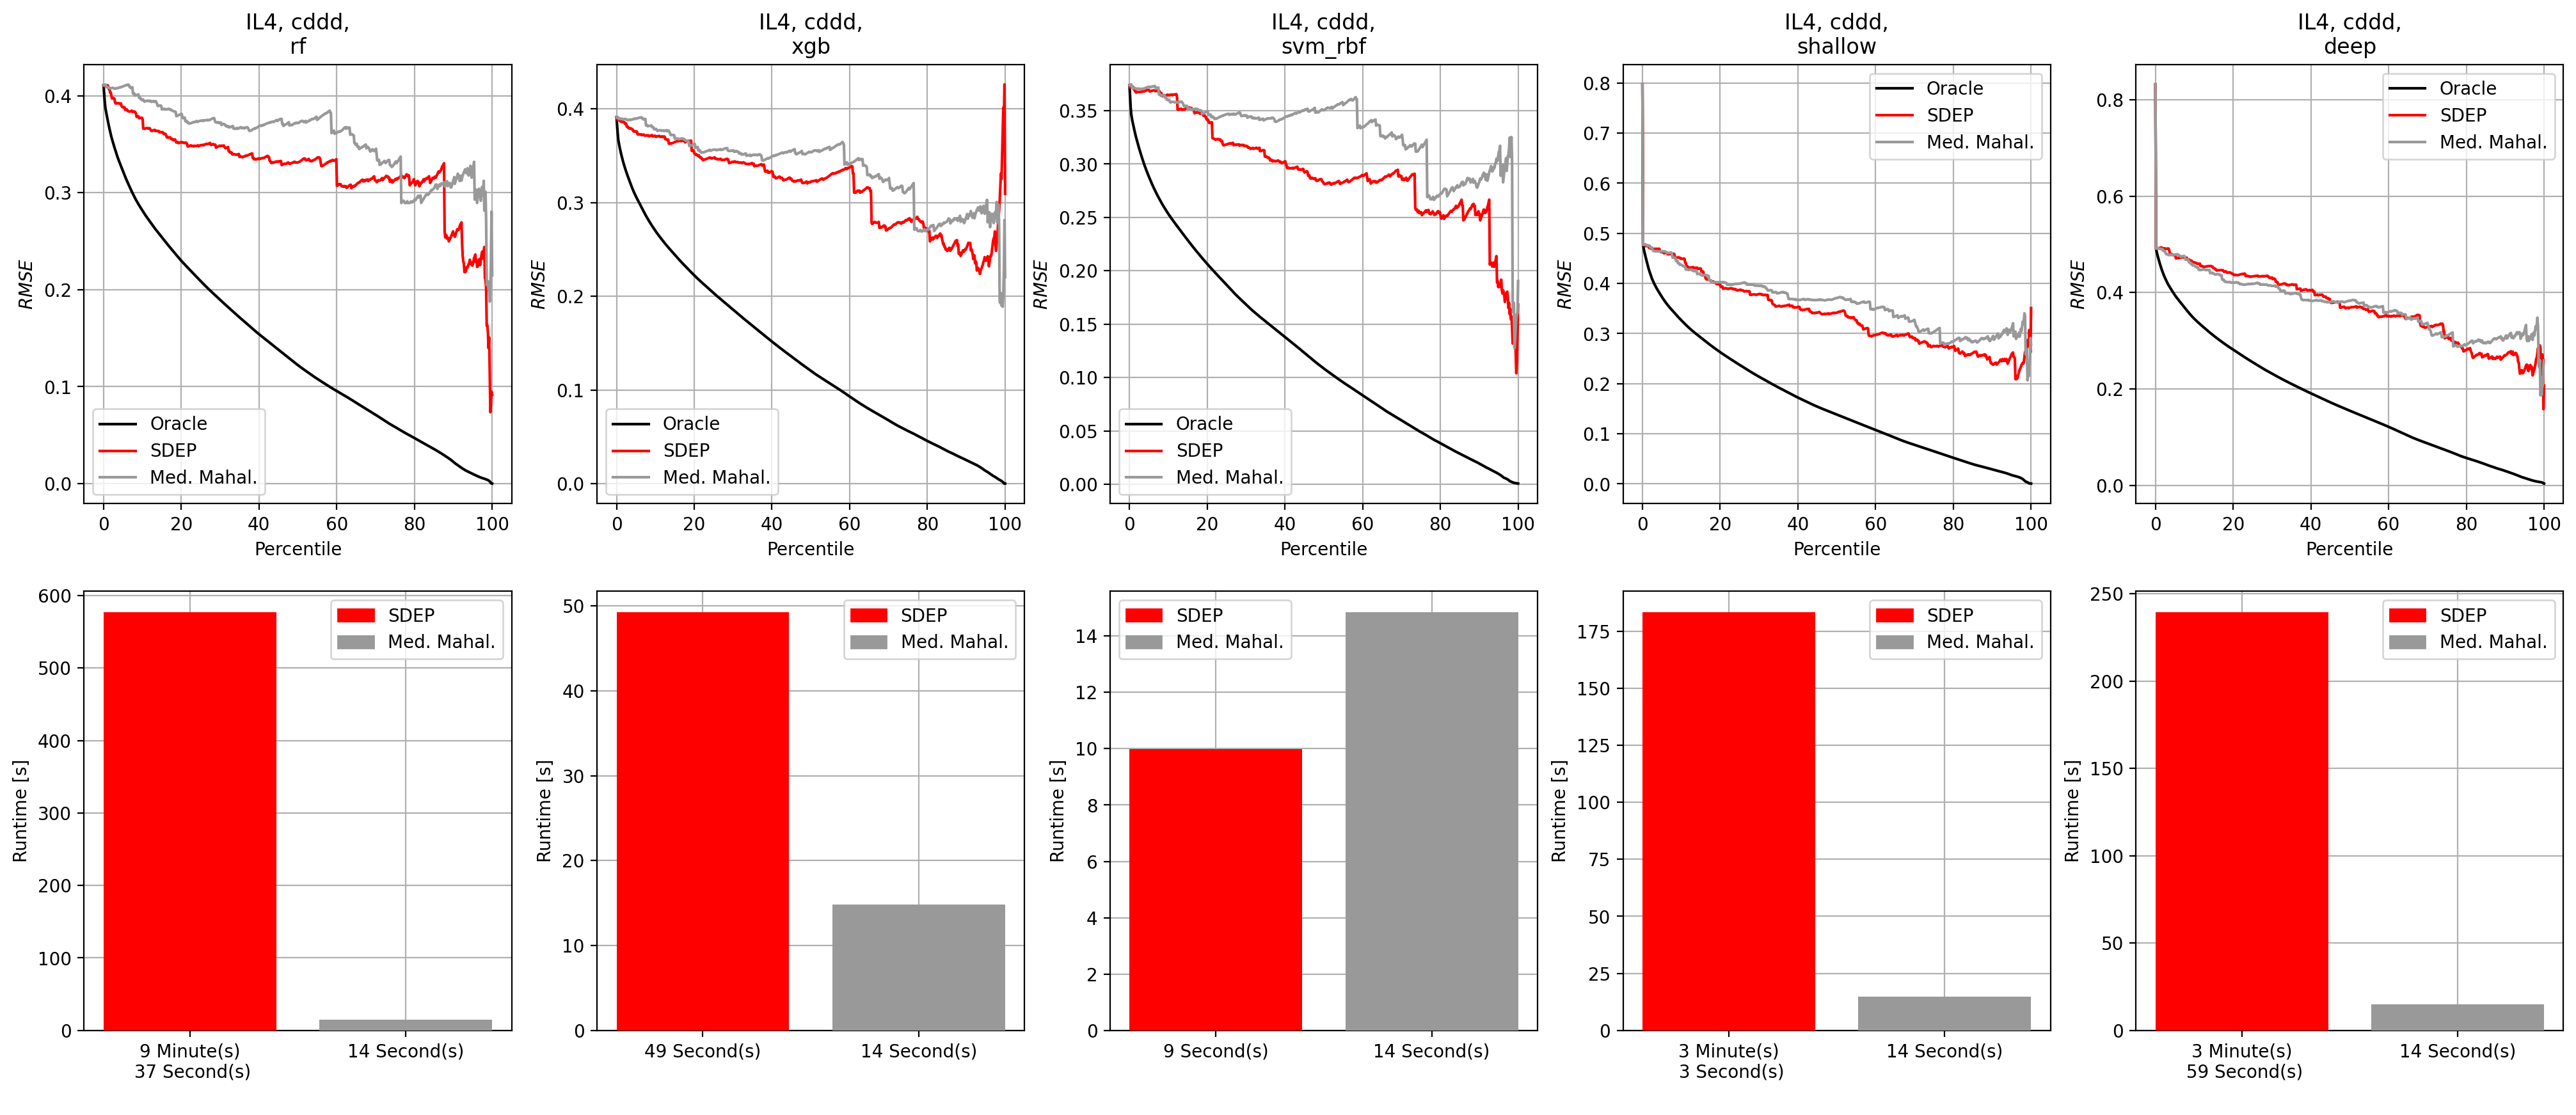

In [15]:
compare_median('IL4', 'cddd', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('IL4', 'cddd', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)

### P49146, RDKit descriptors, large-scale evaluation

100%|██████████| 5/5 [00:00<00:00, 42.11it/s]

Computing Mahalanobis distances.
Running evaluators.



  0%|          | 0/5 [00:00<?, ?it/s]

At rf.


 20%|██        | 1/5 [00:00<00:00,  5.92it/s]

At xgb.


 60%|██████    | 3/5 [00:00<00:00, 22.66it/s]

At svm_rbf.


  0%|          | 0/5 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/5 [00:00<?, ?it/s]

At deep.


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Plotting.


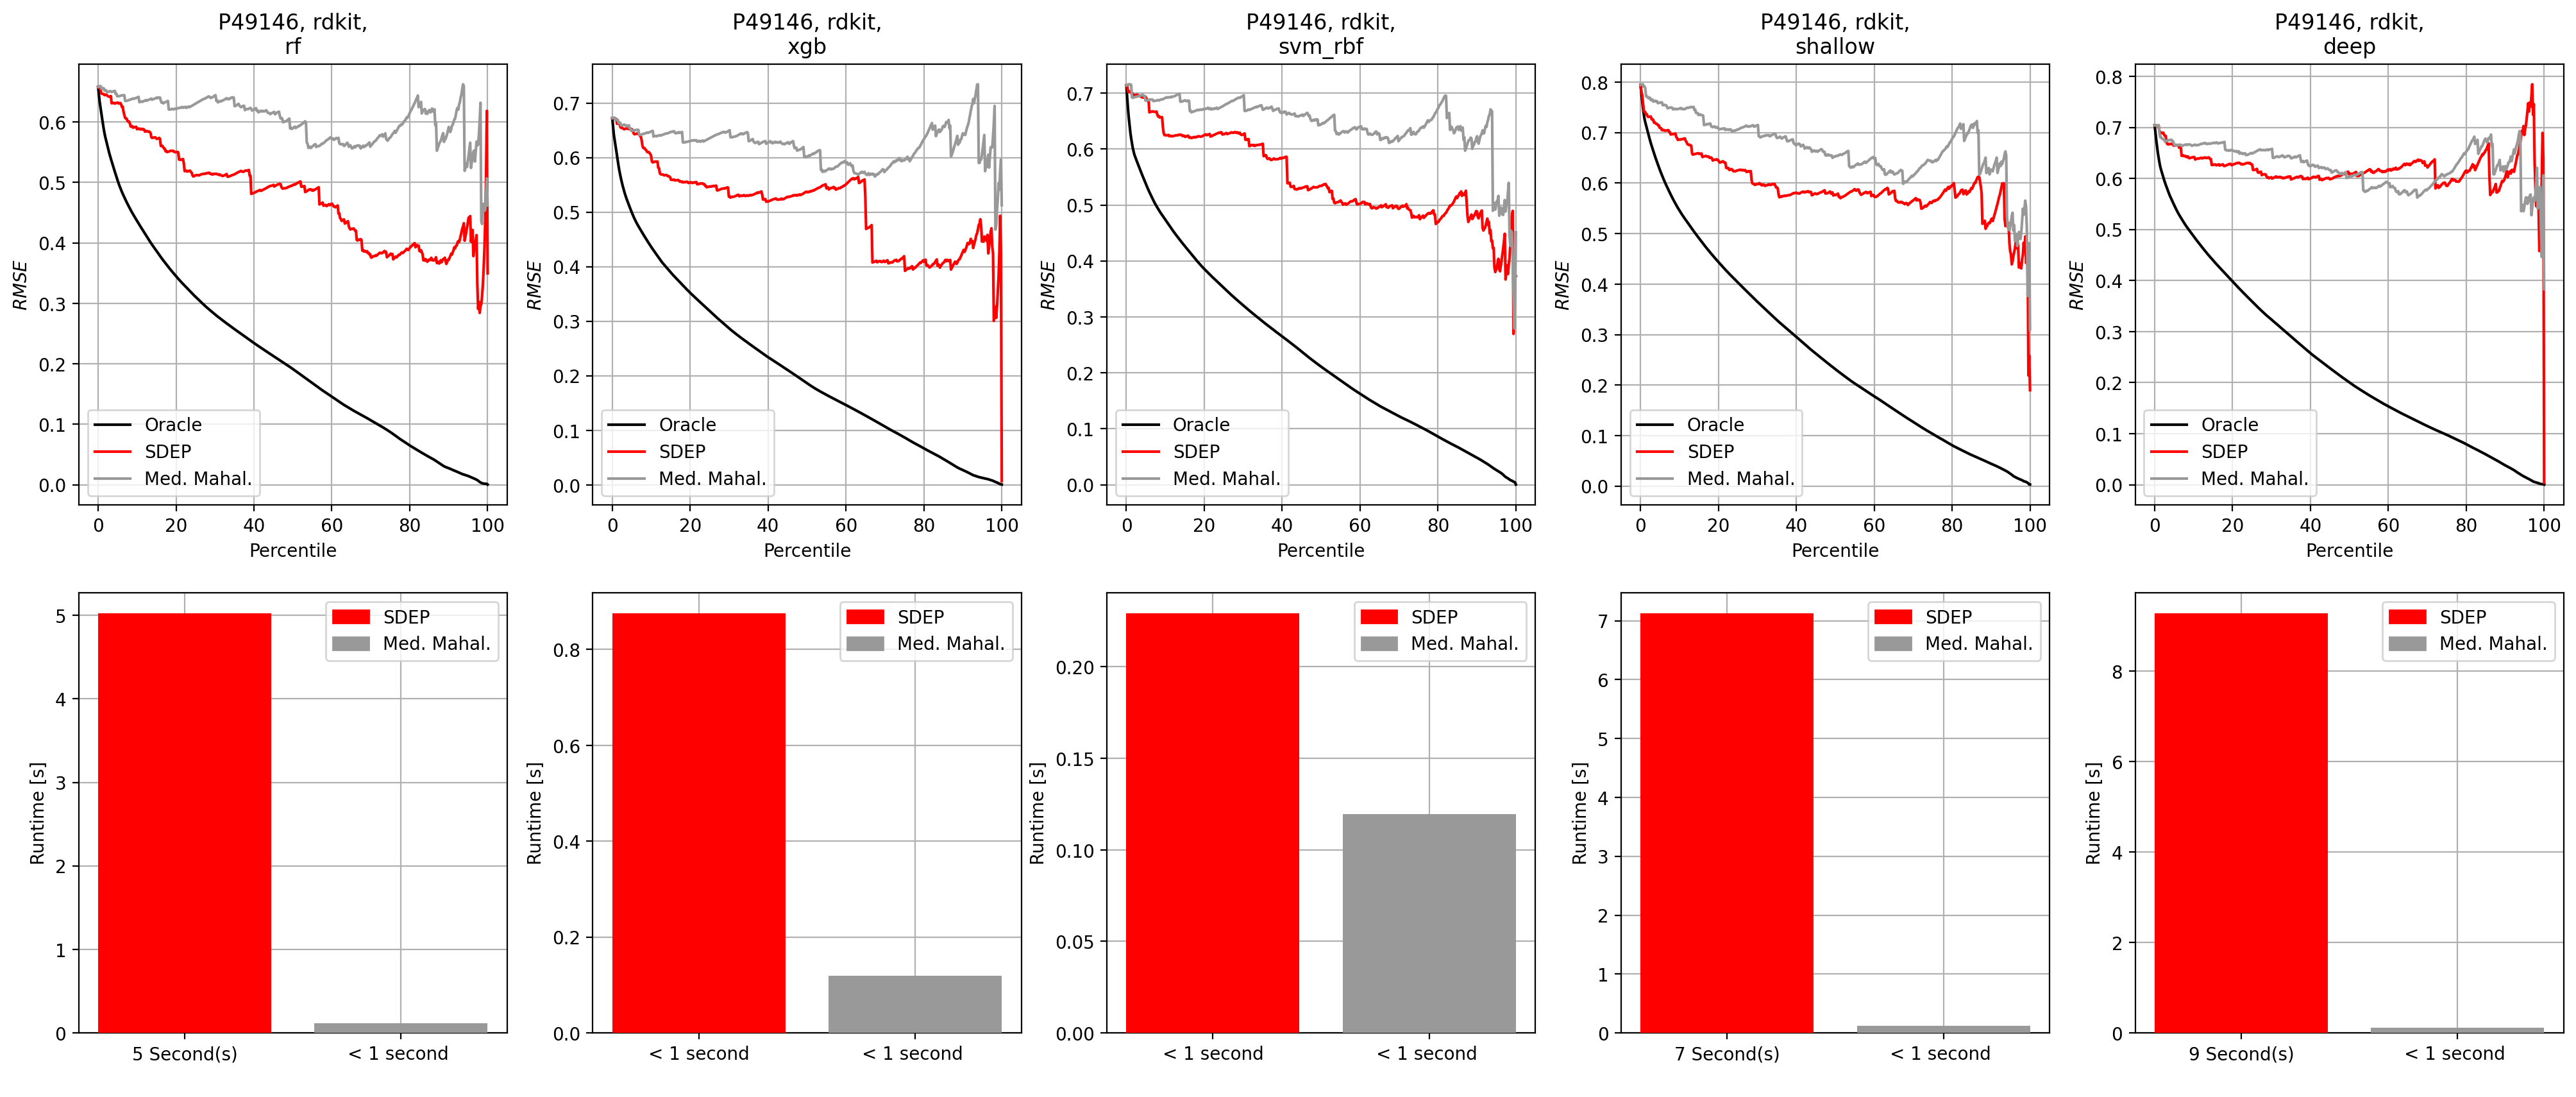

  5%|▌         | 5/100 [00:00<00:02, 46.10it/s]

Computing Mahalanobis distances.


  0%|          | 0/100 [00:00<?, ?it/s]

Running evaluators.
At rf.


  1%|          | 1/100 [00:00<00:16,  5.95it/s]

At xgb.


  3%|▎         | 3/100 [00:00<00:04, 22.32it/s]

At svm_rbf.


  0%|          | 0/100 [00:00<?, ?it/s]

At shallow.


  0%|          | 0/100 [00:00<?, ?it/s]

At deep.


100%|██████████| 100/100 [03:10<00:00,  1.91s/it]


Plotting.


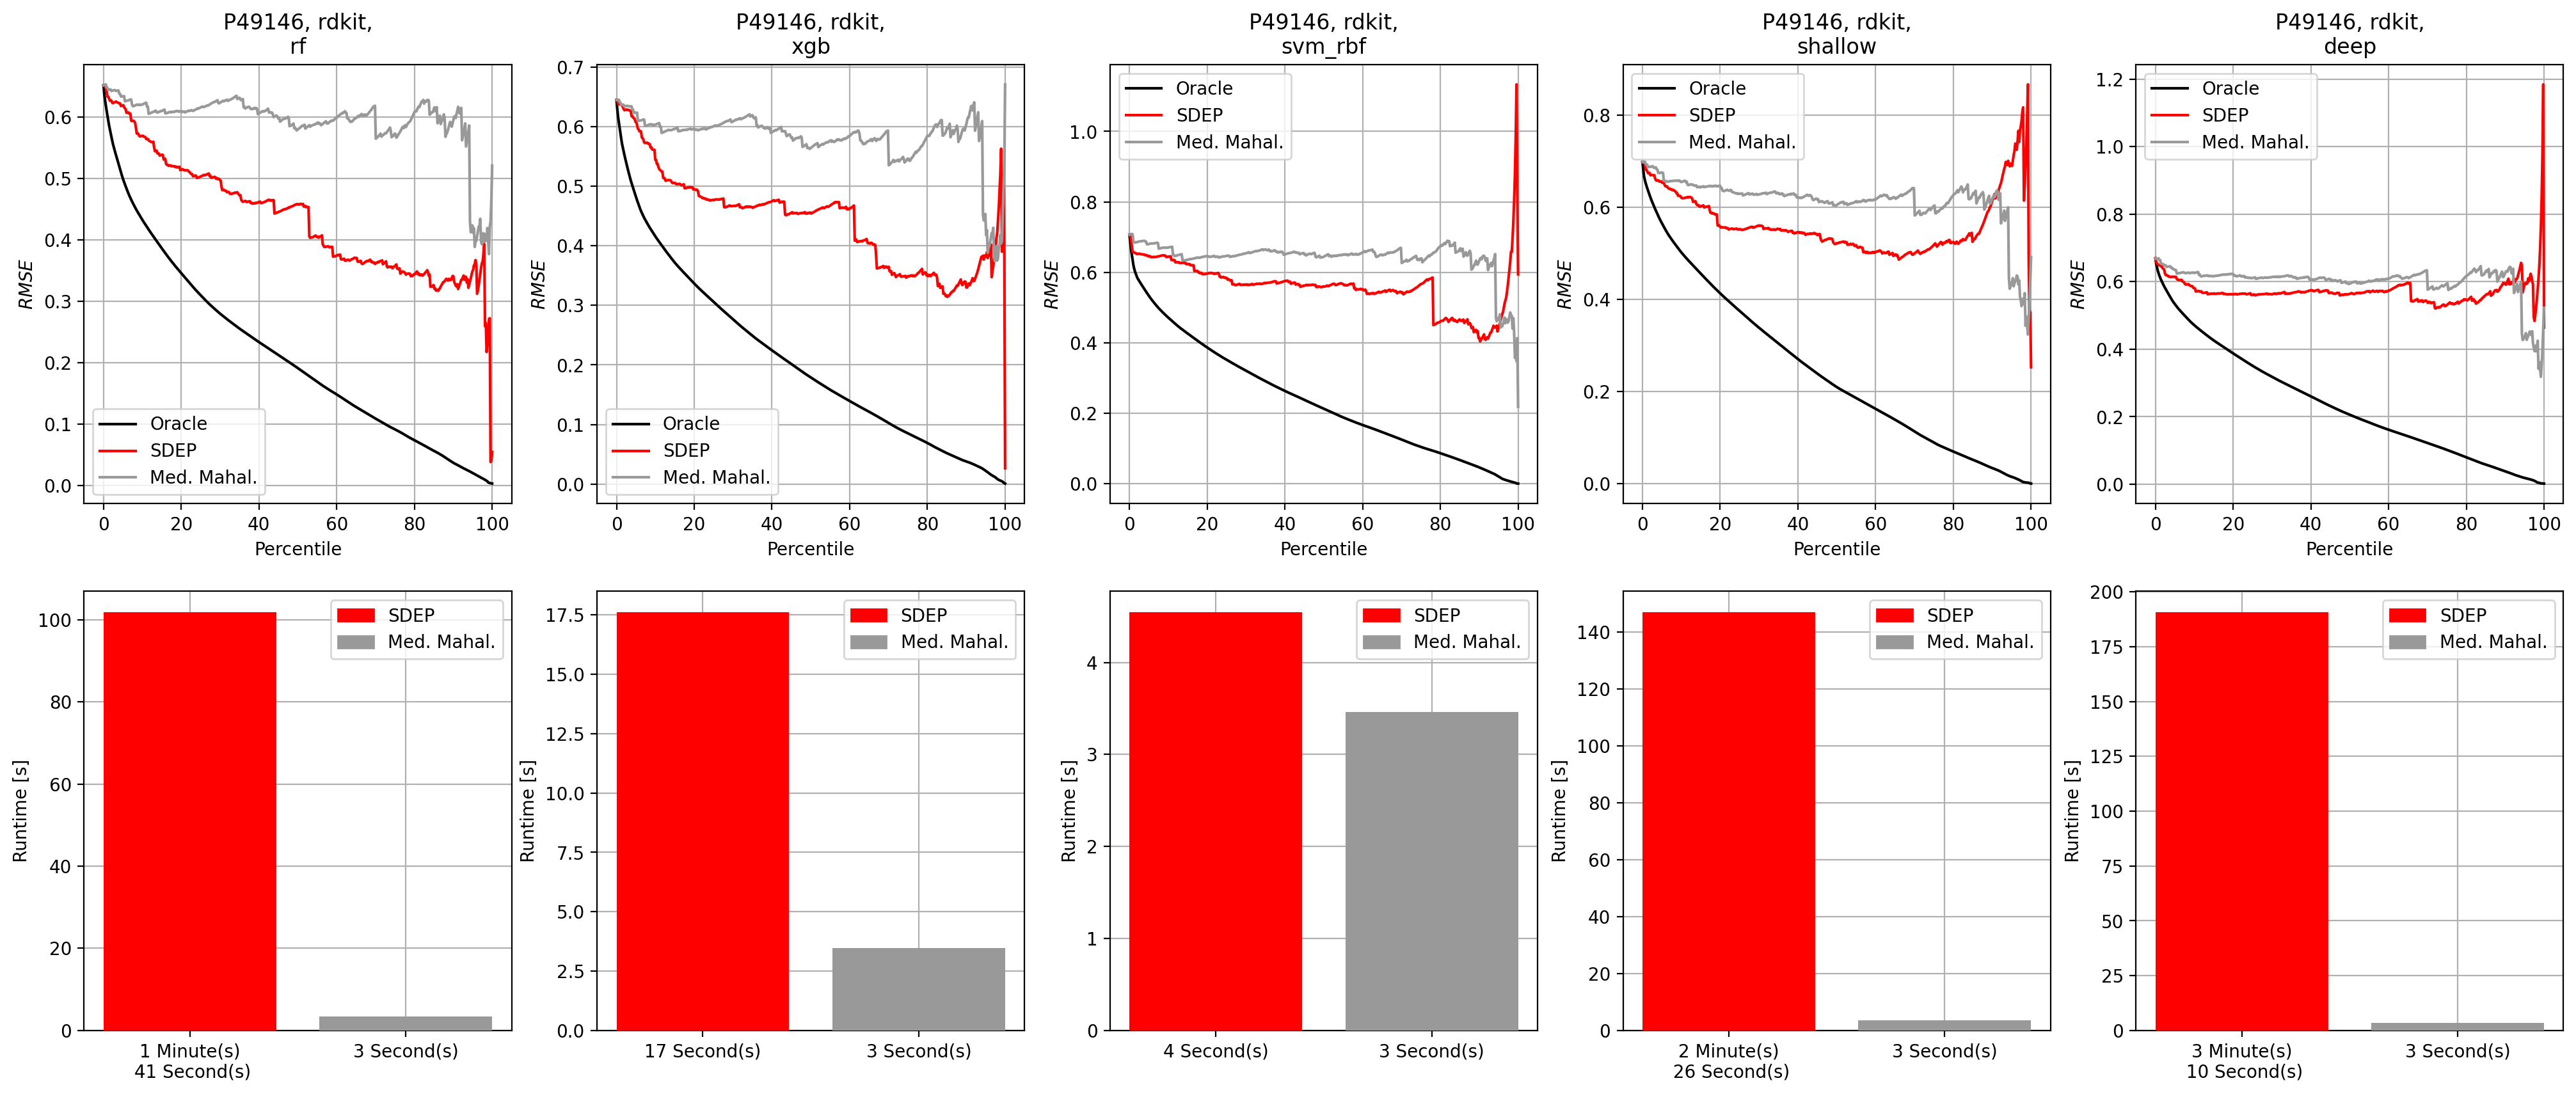

In [16]:
compare_median('P49146', 'rdkit', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 5)
compare_median('P49146', 'rdkit', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], 100)